In [291]:
import numpy as np 
import matplotlib.pyplot as plt
from module_2D_coupling_FV_nogrid import * 
import reconst_and_test_module as post
import random 
import scipy as sp
from scipy import sparse
import scipy.sparse.linalg

plt.rcParams.update({'font.size': 24})
plt.rcParams["figure.figsize"] = (12,12)

In [292]:
!jt -t grade3 -tf merriserif -tfs 14 -nf ptsans -nfs 14 -ofs 150

In [293]:
def execute_full_problem(h_ss,ratio,S):
    #1-Set up the domain
    D=1
    L=6
    #Rv=np.exp(-2*np.pi)*h_ss
    Rv=0.01
    C0=1
    K_eff=1/(np.pi*Rv**2)
    print("D={}, L={}, h_ss={}, ratio={}, #ofSources={}, Rv={}, K_eff={}".format(D, L, h_ss, ratio, S, Rv, K_eff))
    validation=False
    real_Dirich=True
    x_ss=np.linspace(h_ss/2, L-h_ss/2, int(L//h_ss))
    y_ss=x_ss

    pos_s=np.random.random((S,2))*2+2

    if real_Dirich:
        A=A_assembly(len(x_ss), len(y_ss))*D/h_ss**2
        #set dirichlet
        B,A=set_TPFA_Dirichlet(0,A, h_ss, get_boundary_vector(len(x_ss), len(y_ss)), np.zeros(len(x_ss)*len(y_ss)),D)
    else:
        A=A_assembly_Dirich(len(x_ss), len(y_ss))*D/h_ss**2
        B=np.zeros(A.shape[0])

    t=assemble_SS_2D_FD(pos_s, A, Rv, h_ss,x_ss,y_ss, K_eff, D,1)
    t.pos_arrays()
    t.initialize_matrices()
    t.assembly_sol_split_problem()
    B_v=np.zeros(len(t.uni_s_blocks))

    B_q=np.ones(len(t.s_blocks))
    B_q[np.random.randint(S-1, size=S//2)]=0
    B=np.concatenate((B,B_v,B_q))

    phi=np.linalg.solve(t.M, B)
    phi_FV, phi_v, phi_q=post.separate_unk(t, phi)
    phi_mat=phi_FV.reshape(len(x_ss), len(y_ss))

    plt.imshow(phi_mat, origin="lower"); plt.colorbar()
    plt.title("Coupling model: real concentration \n field reconstruction")
    plt.show()
    o=post.reconstruct_coupling(phi, 1, t,1)
    rec=o.reconstruction(ratio)
    
    plt.imshow(rec, extent=[0,L,0,L], origin='lower')
    plt.title("Couplin model: linear flux microscopic\n reconstruction for the regular term")
    plt.colorbar()
    plt.show()
    
    a=full_ss(pos_s, Rv, h_ss/ratio, K_eff, D,L)
    SS=a.solve_problem(B_q)
    SS=a.reconstruct(a.v, a.phi_q)
    plt.show()
    
    plt.imshow(SS, origin="lower", extent=[0,L,0,L]); plt.colorbar()
    title_string="Validation Full_SS \n refined ($h_{SS}=h_{coupling}$" + "*$\dfrac{1}{%d}$)" % ratio
    plt.title(title_string)
    plt.show()
    #reconstruct the full solution splitting
    a.uni_s_blocks=np.array([])
    a.s_blocks=np.array([])
    a.FV_DoF=np.arange(len(a.v))
    
    sol, xlen2, ylen2,q_array,aa, Y, s_b,x_v, y_v=get_validation(ratio, t, pos_s, B_q, D, K_eff, Rv,L)
    plt.imshow(sol.reshape(ylen2, xlen2), origin='lower'); plt.colorbar()
    title_string="Comparison FV \n refined ($h_{FV}=h_{coupling}$" + "*$\dfrac{1}{%d}$)" % ratio
    plt.title(title_string)
    plt.show()
    
    plt.figure()
    title_string="Comparison of flux estimation (q) through \n the three different schemes for \n a ratio in \
    discretization: $h_{SS}=h_{FV}=h_{coupling}$" + "*$\dfrac{1}{%d}$ \n and %d sources" % (ratio, S)
    plt.plot(phi_q, label="coupling", marker='*')
    plt.plot(a.phi_q, label="Full_SS",marker='*')
    plt.plot(q_array, label="fine FV",marker='*')
    plt.title(title_string)
    plt.legend()
    
    #error plots
    error_fv=(q_array-a.phi_q)/a.phi_q
    error_coup=(phi_q-a.phi_q)/a.phi_q
    plt.figure(figsize=(12,12))


    fig, axs=plt.subplots(1,2, figsize=(16,10))
    fig.suptitle("Flux estimation for S={}".format(S), fontsize=44)
    im=axs[0].plot(np.arange(S),phi_q, label="coupling")
    im=axs[0].plot(np.arange(S),a.phi_q, label="Full_SS")
    im=axs[0].plot(np.arange(S),q_array, label="fine FV ($h_{FV}=h\cdot\dfrac{1}{%d}$)" % ratio)
    axs[0].legend()
    axs[0].set_title("Absolute flux")
    im=axs[1].plot(np.arange(S),np.abs(error_fv), label="fine FV ($h_{FV}=h\cdot\dfrac{1}{%d}$)" % ratio)
    im=axs[1].plot(np.arange(S),np.abs(error_coup), label="coupling")
    axs[1].set_title("relative error: \n finite volumes vs coupling model")
    fig.tight_layout()
    plt.legend()
    plt.show()
    
    get_L2(a.phi_q, q_array, "FV", ratio)
    get_L2(a.phi_q, phi_q, "coupling", 1)

In [343]:
#1-Set up the domain
D=1
L=6
h_ss=1
#Rv=np.exp(-2*np.pi)*h_ss
Rv=0.01
C0=1
K_eff=1/(np.pi*Rv**2)

validation=False
real_Dirich=True
x_ss=np.linspace(h_ss/2, L-h_ss/2, int(L//h_ss))
y_ss=x_ss

In [344]:
S=30
pos_s=np.random.random((S,2))*2+2

In [345]:
if real_Dirich:
    A=A_assembly(len(x_ss), len(y_ss))*D/h_ss**2
    #set dirichlet
    B,A=set_TPFA_Dirichlet(0,A, h_ss, get_boundary_vector(len(x_ss), len(y_ss)), np.zeros(len(x_ss)*len(y_ss)),D)
else:
    A=A_assembly_Dirich(len(x_ss), len(y_ss))*D/h_ss**2
    B=np.zeros(A.shape[0])

In [346]:
t=assemble_SS_2D_FD(pos_s, A, Rv, h_ss,x_ss,y_ss, K_eff, D,1)
t.pos_arrays()
t.initialize_matrices()
t.assembly_sol_split_problem()
B_v=np.zeros(len(t.uni_s_blocks))


In [347]:
B_q=np.ones(len(t.s_blocks))
B_q[np.random.randint(S-1, size=S//2)]=0
B=np.concatenate((B,B_v,B_q))

In [348]:
phi=np.linalg.solve(t.M, B)
phi_FV, phi_v, phi_q=post.separate_unk(t, phi)
phi_mat=phi_FV.reshape(len(x_ss), len(y_ss))

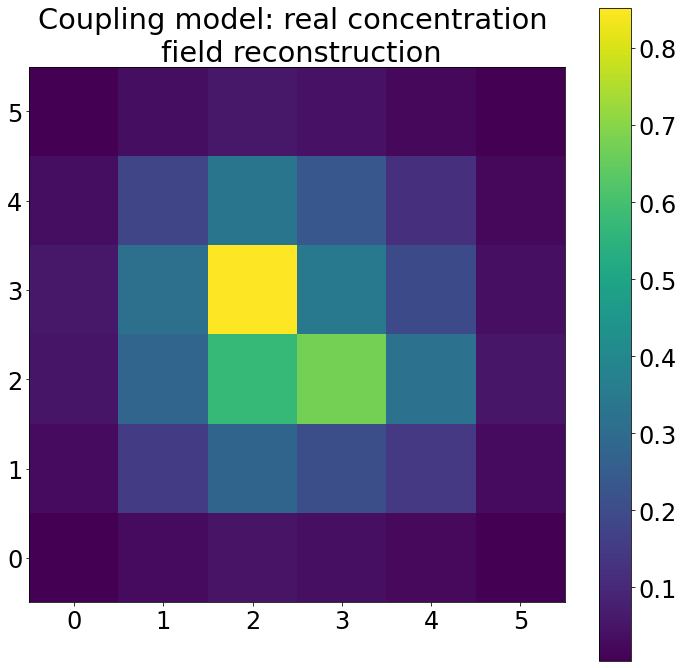

In [349]:
plt.imshow(phi_mat, origin="lower"); plt.colorbar()
plt.title("Coupling model: real concentration \n field reconstruction")
plt.show()

In [350]:
ratio=20

In [351]:
o=post.reconstruct_coupling(phi, 1, t,1)
rec=o.reconstruction(ratio)

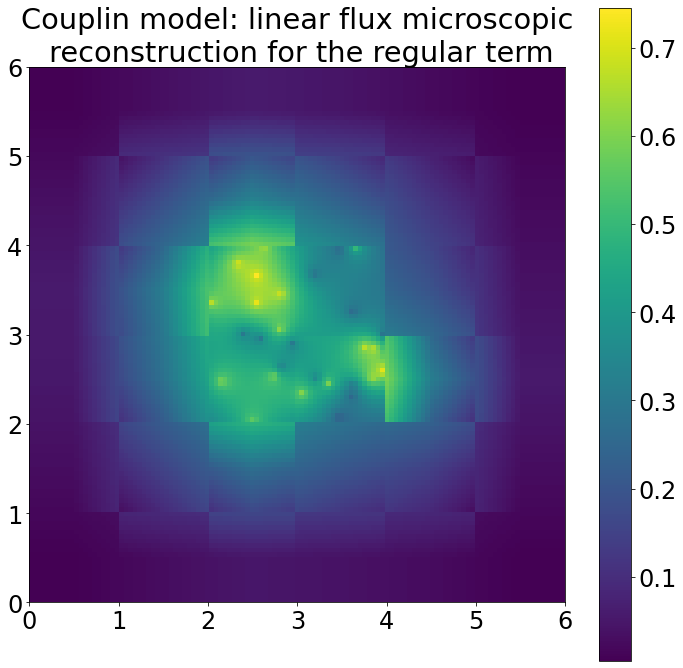

In [352]:
plt.imshow(rec, extent=[0,L,0,L], origin='lower')
plt.title("Couplin model: linear flux microscopic\n reconstruction for the regular term")
plt.colorbar()
plt.show()
    

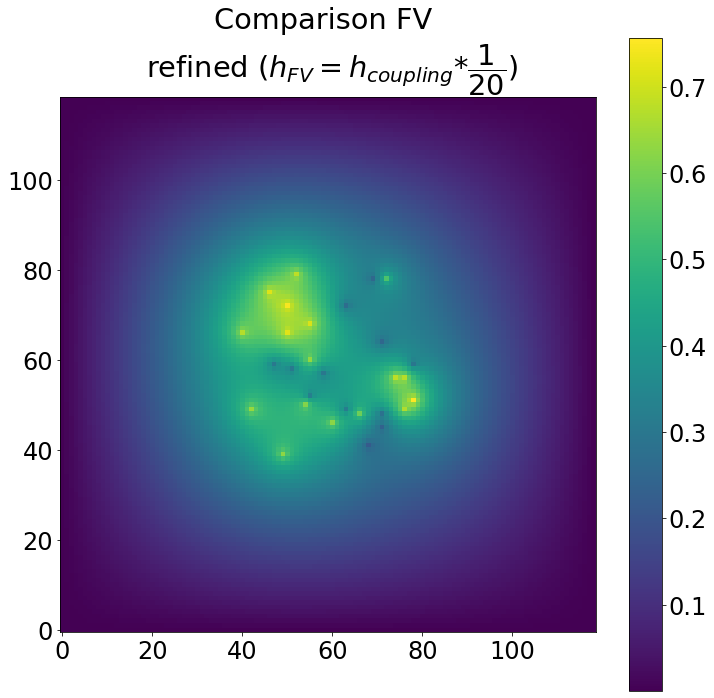

In [353]:
sol, xlen2, ylen2,q_array,aa, Y, s_b,x_v, y_v=get_validation(ratio, t, pos_s, B_q, D, K_eff, Rv,L)
plt.imshow(sol.reshape(ylen2, xlen2), origin='lower'); plt.colorbar()
title_string="Comparison FV \n refined ($h_{FV}=h_{coupling}$" + "*$\dfrac{1}{%d}$)" % ratio
plt.title(title_string)
plt.show()

[-0.30439124 -0.30544577  0.32298477 -0.32420247  0.35701184  0.28215706
  0.25267744  0.37519239  0.29141496  0.36716551 -0.28250672 -0.25417606
  0.27972384 -0.27225649 -0.32252118  0.33098891  0.37166057 -0.29680884
  0.32846395 -0.21738639  0.40354229  0.45088951  0.31489192  0.27129146
  0.35987832 -0.30062336 -0.24179916 -0.24954731  0.31951164  0.27268313]


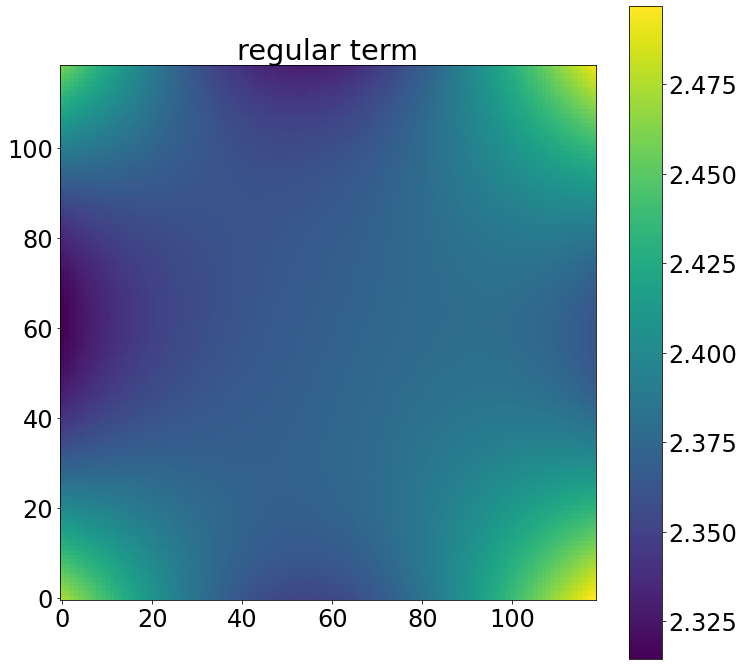

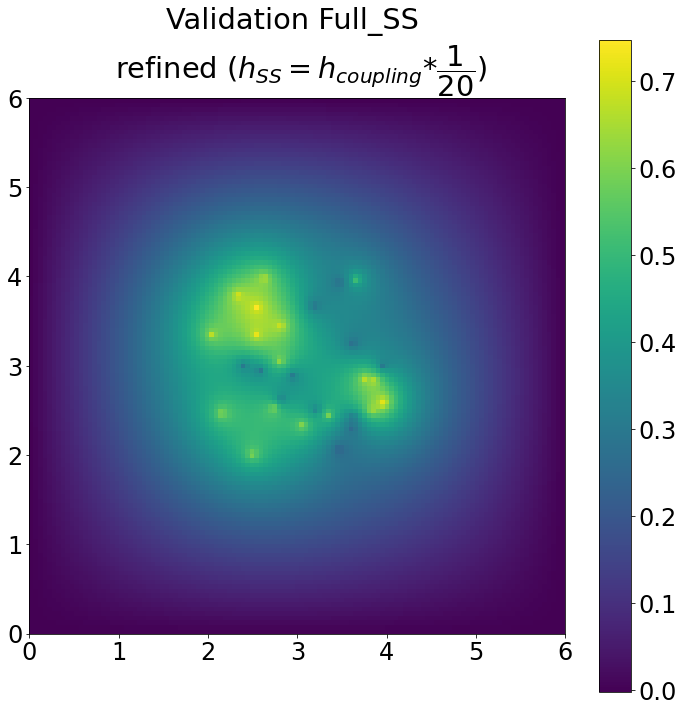

In [354]:

a=full_ss(pos_s, Rv, h_ss/ratio, K_eff, D,L)
SS=a.solve_problem(B_q)
SS=a.reconstruct(a.v, a.phi_q)
plt.show()
plt.imshow(SS, origin="lower", extent=[0,L,0,L]); plt.colorbar()
title_string="Validation Full_SS \n refined ($h_{SS}=h_{coupling}$" + "*$\dfrac{1}{%d}$)" % ratio
plt.title(title_string)
plt.show()
#reconstruct the full solution splitting
a.uni_s_blocks=np.array([])
a.s_blocks=np.array([])
a.FV_DoF=np.arange(len(a.v))

In [355]:
grads_v=post.reconstruction_gradients_manual(a.v, a, a.boundary)
v_rec=post.reconstruct_from_gradients(a.v, grads_v, 5, a.x, a.y, a.h)


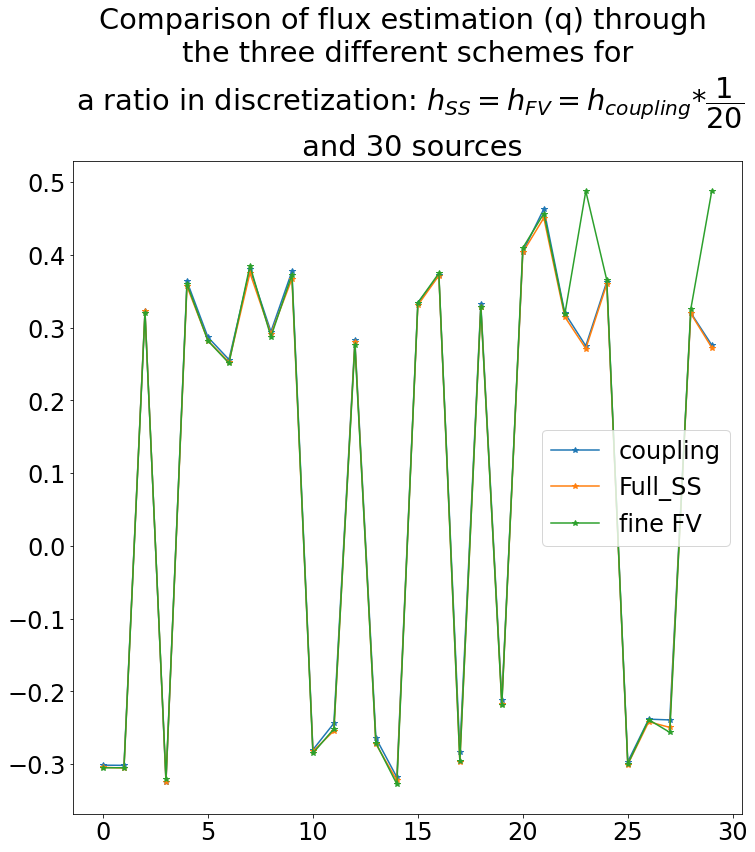

In [356]:
plt.figure()
plt.plot(phi_q, label="coupling", marker='*')
plt.plot(a.phi_q, label="Full_SS",marker='*')
plt.plot(q_array, label="fine FV",marker='*')
title_string="Comparison of flux estimation (q) through \n the three different schemes for \n a ratio in \
discretization: $h_{SS}=h_{FV}=h_{coupling}$" + "*$\dfrac{1}{%d}$ \n and %d sources" % (ratio, S)
plt.title(title_string)
plt.legend()


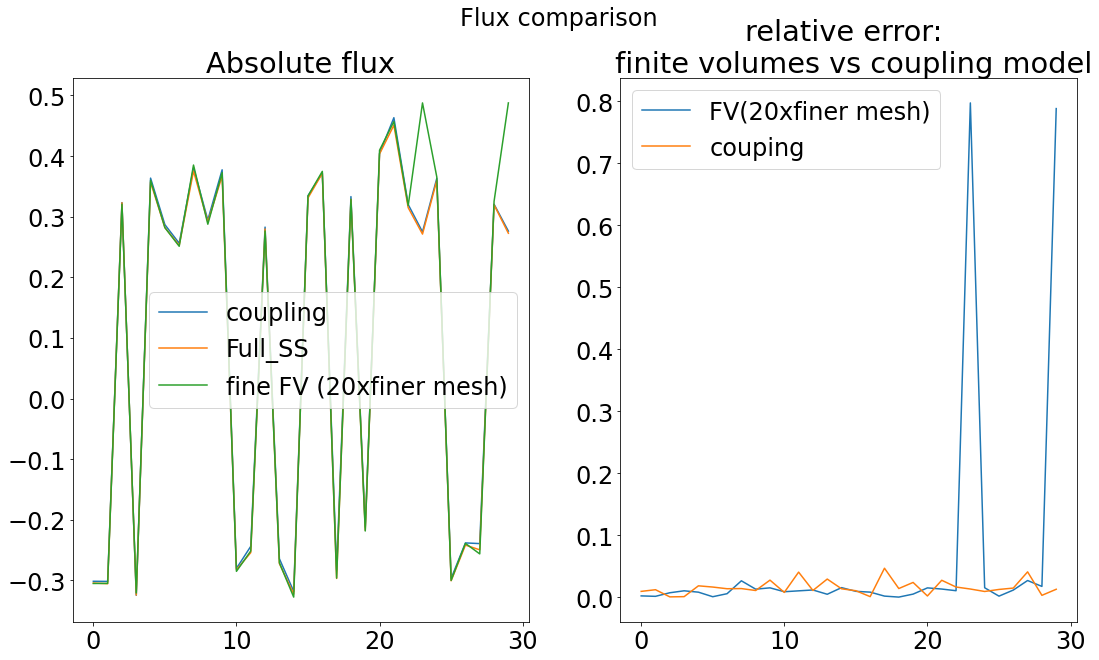

In [357]:
#error plots
error_fv=(q_array-a.phi_q)/a.phi_q
error_coup=(phi_q-a.phi_q)/a.phi_q


fig, axs=plt.subplots(1,2, figsize=(18,10))
fig.suptitle("Flux comparison", fontsize=24)
im=axs[0].plot(np.arange(S),phi_q, label="coupling")
im=axs[0].plot(np.arange(S),a.phi_q, label="Full_SS")
im=axs[0].plot(np.arange(S),q_array, label="fine FV ({}xfiner mesh)".format(ratio))
axs[0].legend()
axs[0].set_title("Absolute flux")
im=axs[1].plot(np.arange(S),np.abs(error_fv), label="FV({}xfiner mesh)".format(ratio))
im=axs[1].plot(np.arange(S),np.abs(error_coup), label="couping")
plt.title("relative error: \n finite volumes vs coupling model")
plt.legend()

In [358]:
def get_L2(val, sol, title, ratio): 
    L2=np.sqrt(np.sum((val-sol)**2))
    string="L^2 norm for the " + title + " with {} refinement= {}".format(ratio, L2)
    print(string)
get_L2(a.phi_q, q_array, "FV", ratio)
get_L2(a.phi_q, phi_q, "coupling", 1)

L^2 norm for the FV with 20 refinement= 0.30580889386961246
L^2 norm for the coupling with 1 refinement= 0.03251424874680782


Text(0.5, 1.0, 'Comparison FV with SS')

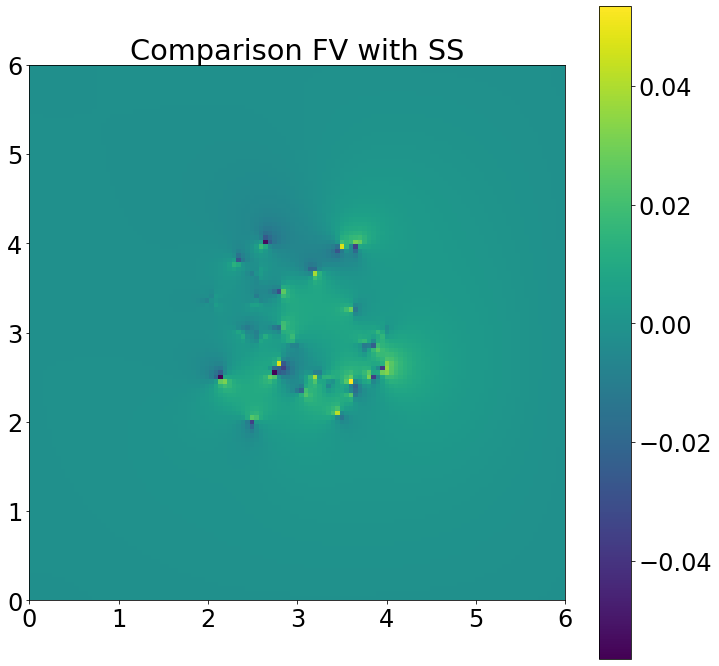

In [359]:
plt.imshow(SS-sol.reshape(xlen2, ylen2) , origin="lower", extent=[0,L,0,L]); plt.colorbar(); plt.title("Comparison FV with SS")

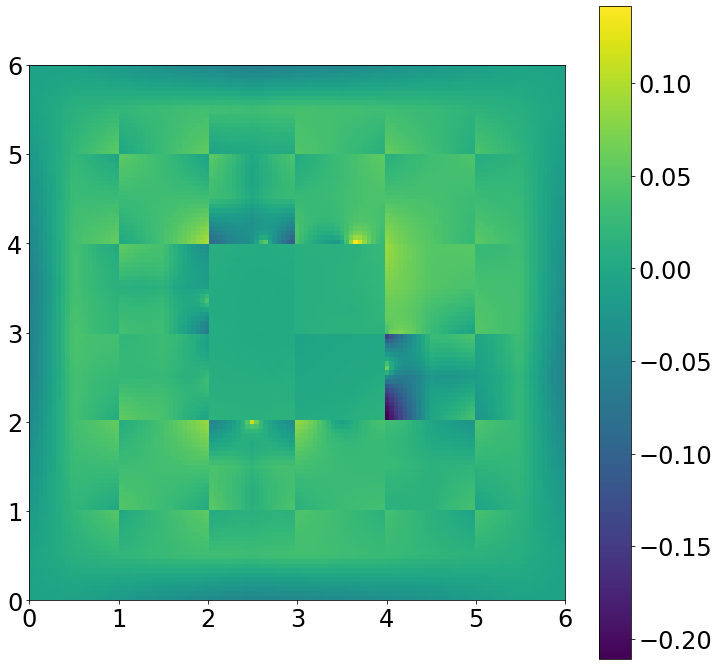

In [363]:
plt.imshow(SS-rec , origin="lower", extent=[0,L,0,L]); plt.colorbar()

Plots through the surfaces

In [360]:
array_of_rows=np.zeros(len(pos_s), dtype=int)
c=0
for i in pos_s:
    array_of_rows[c]=np.argmin(np.abs(x_v-i[0]))
    c+=1
print(array_of_rows)

[51 47 74 63 42 46 50 54 55 49 71 71 50 63 55 76 60 78 40 68 66 72 52 78
 55 58 71 69 76 78]


<ipython-input-362-f434f634b6fa>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


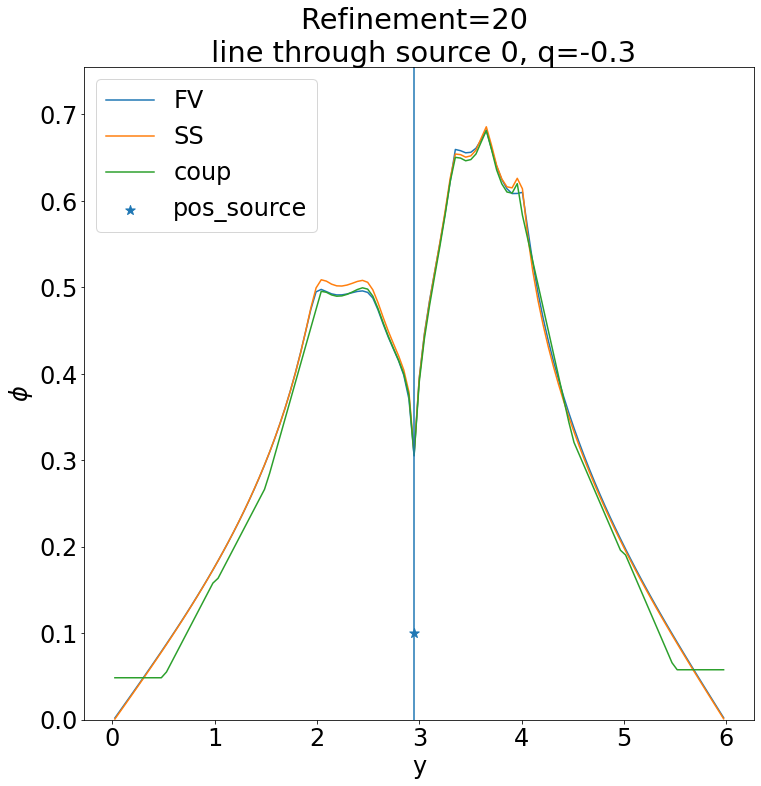

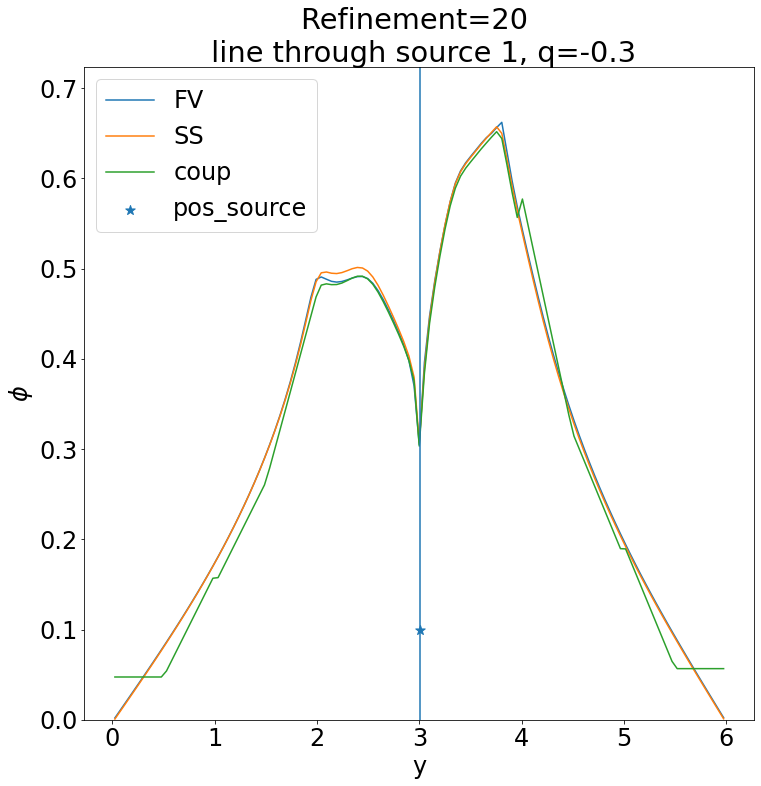

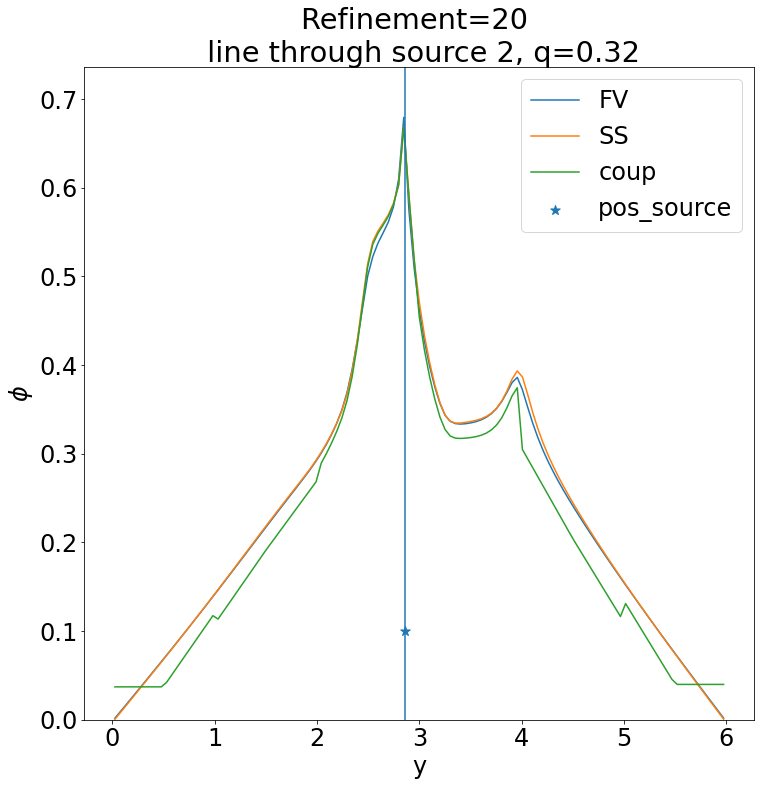

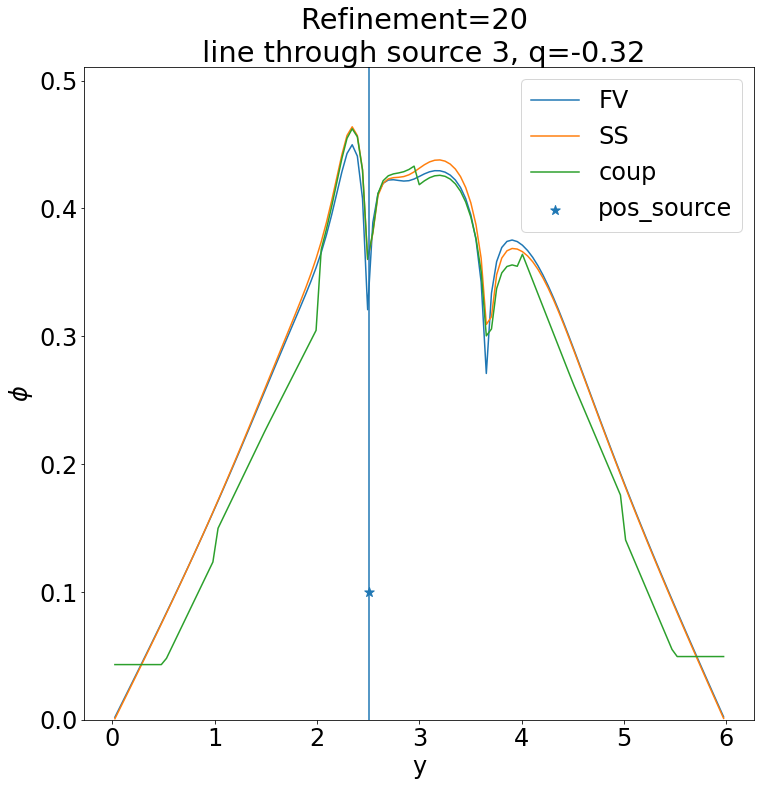

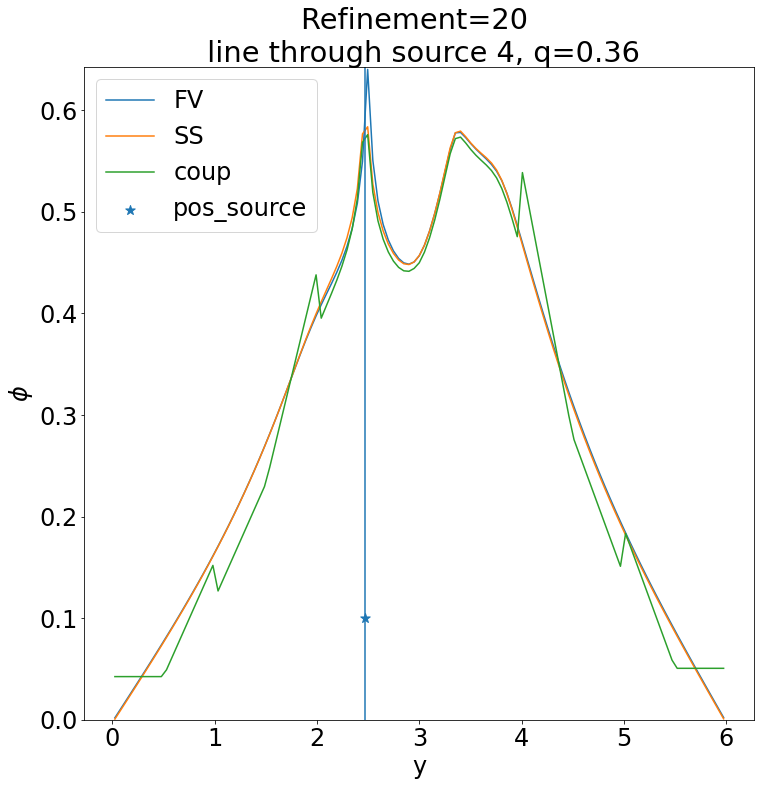

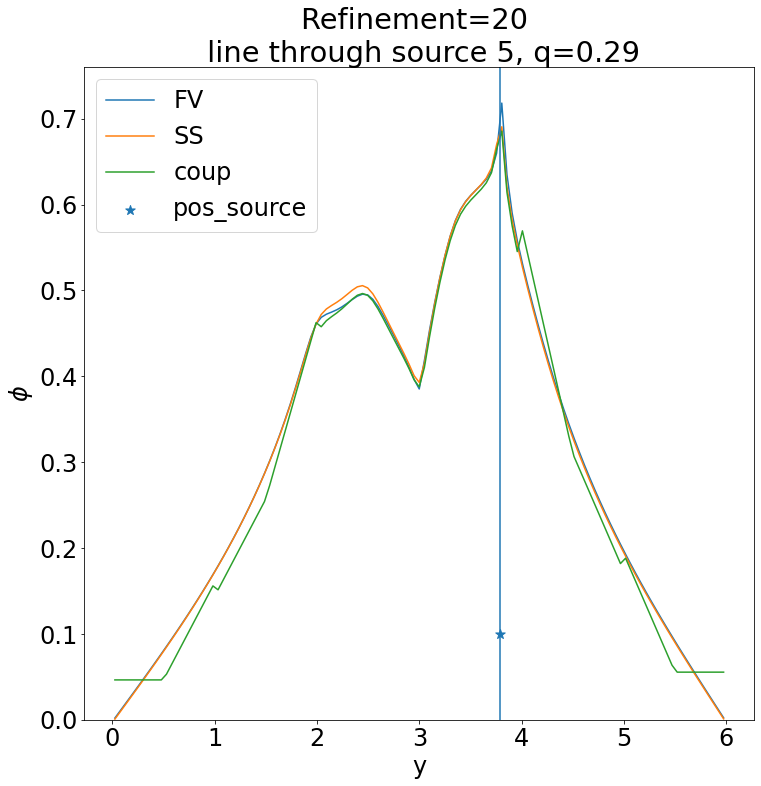

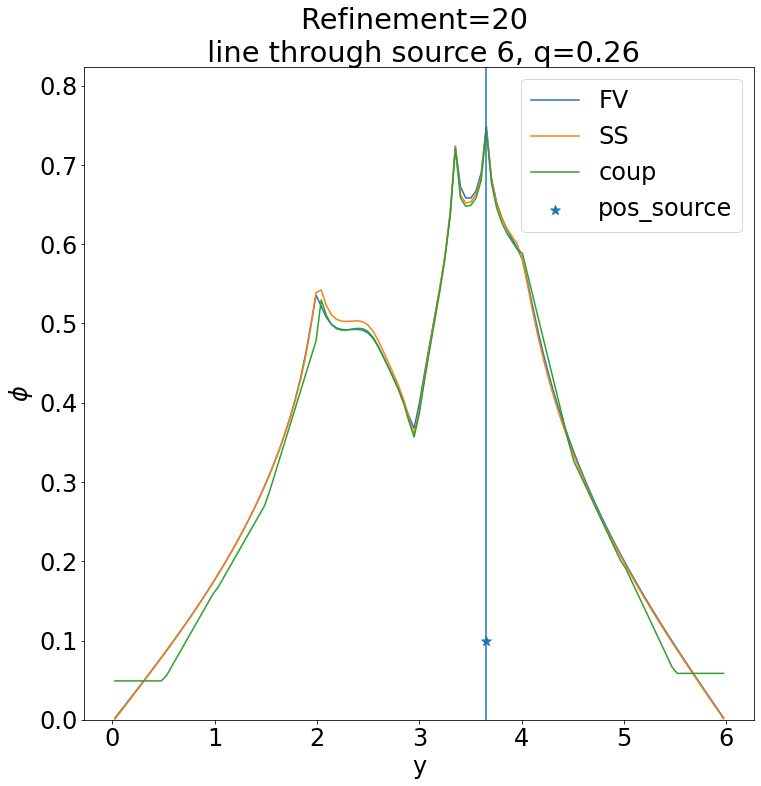

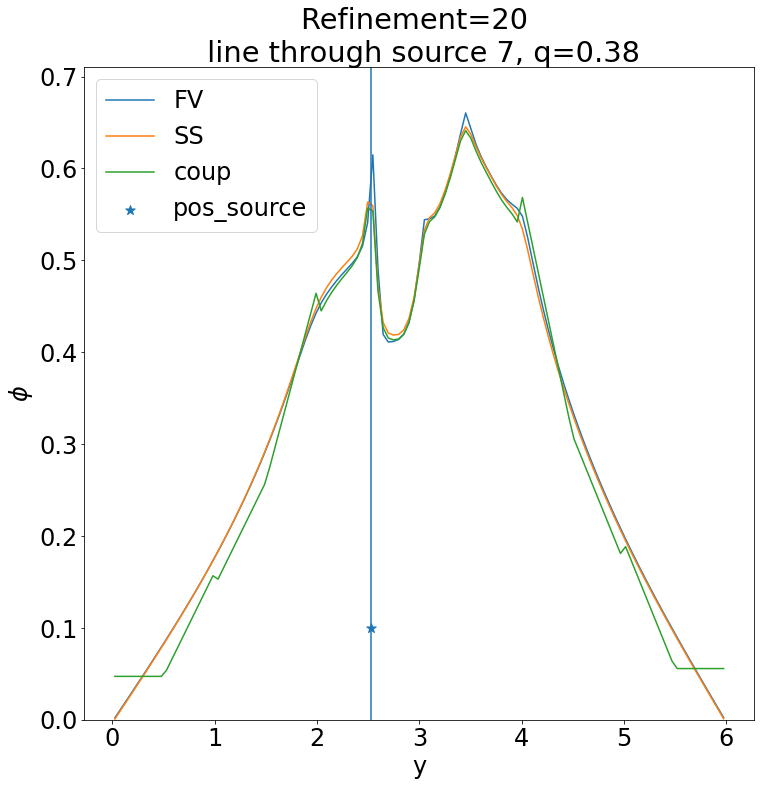

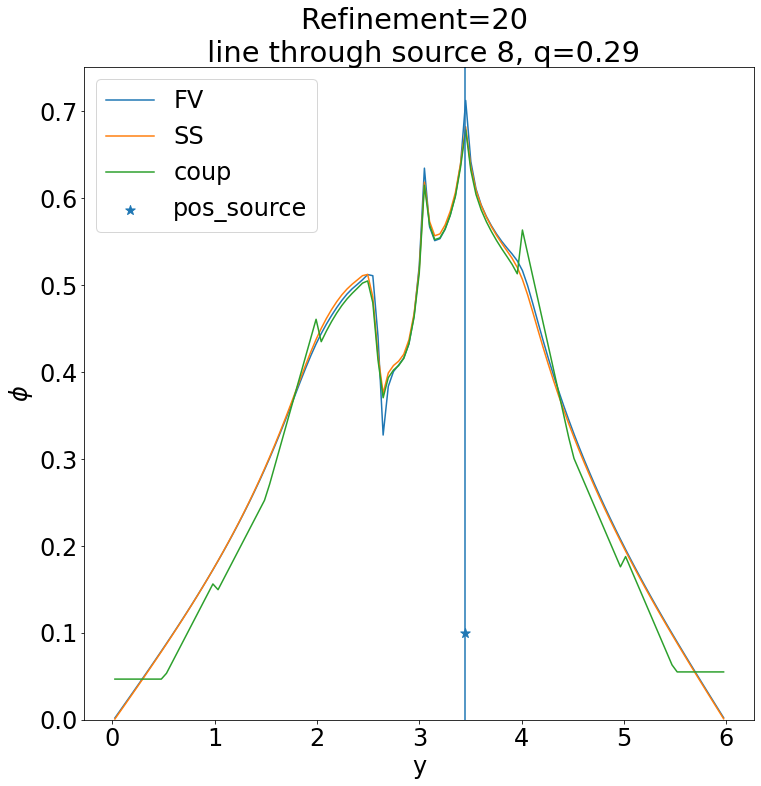

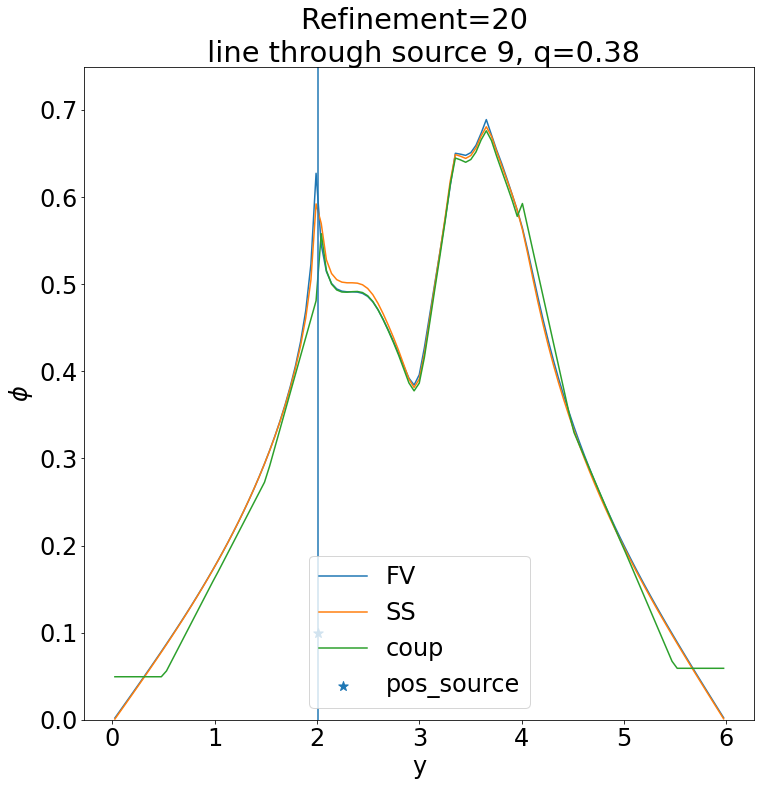

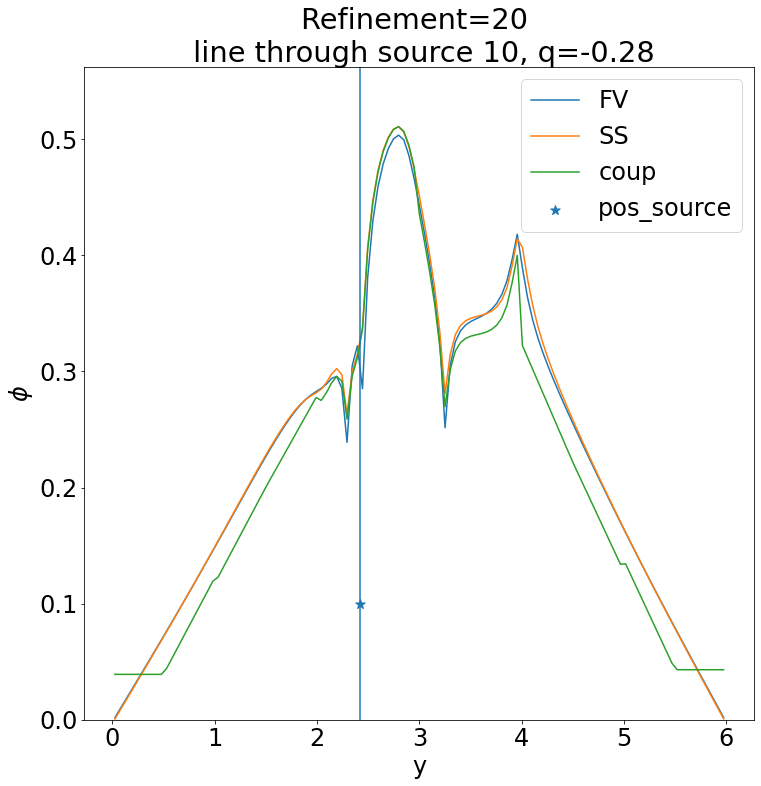

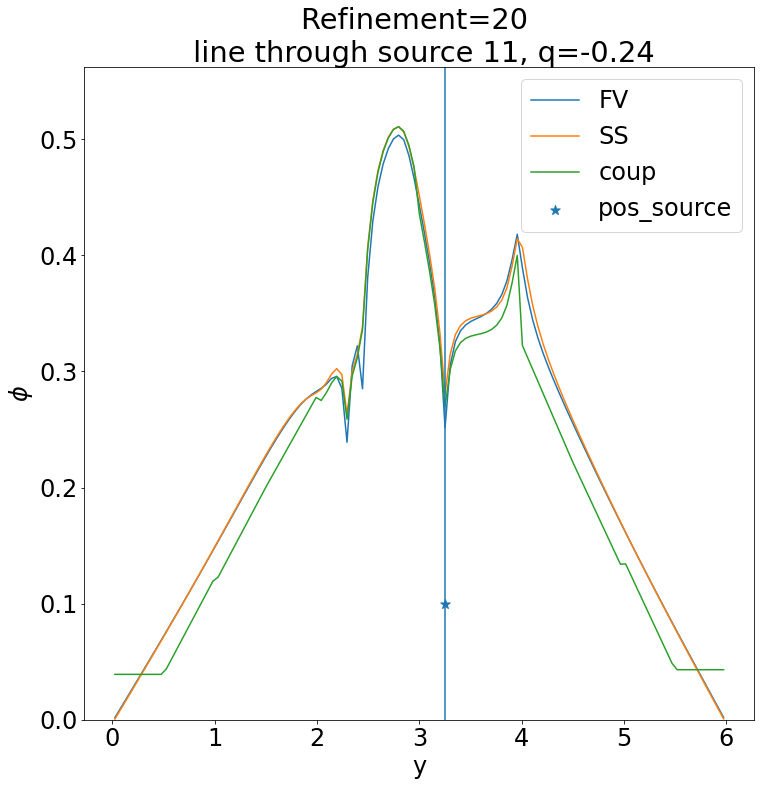

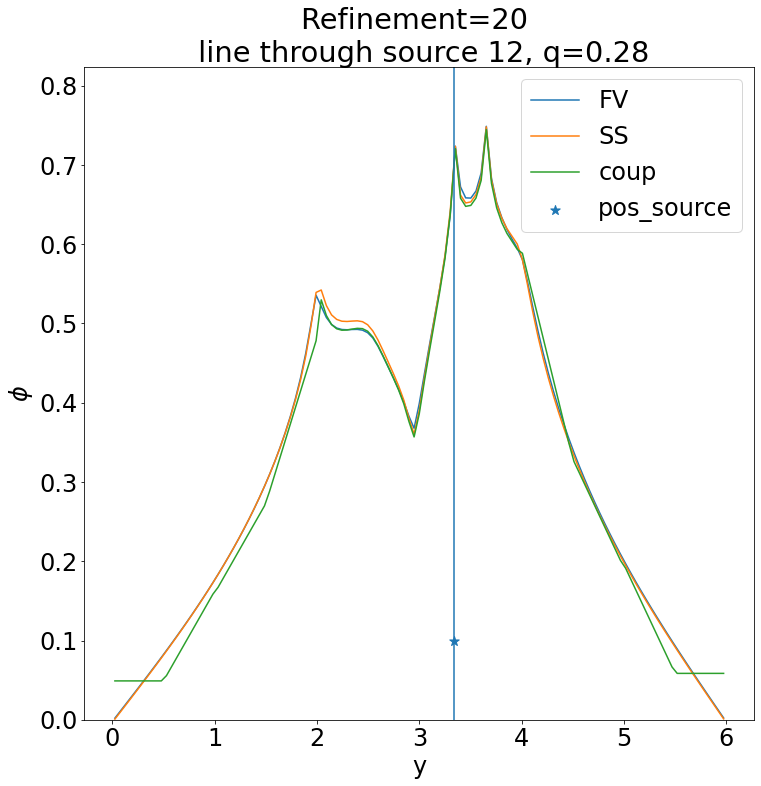

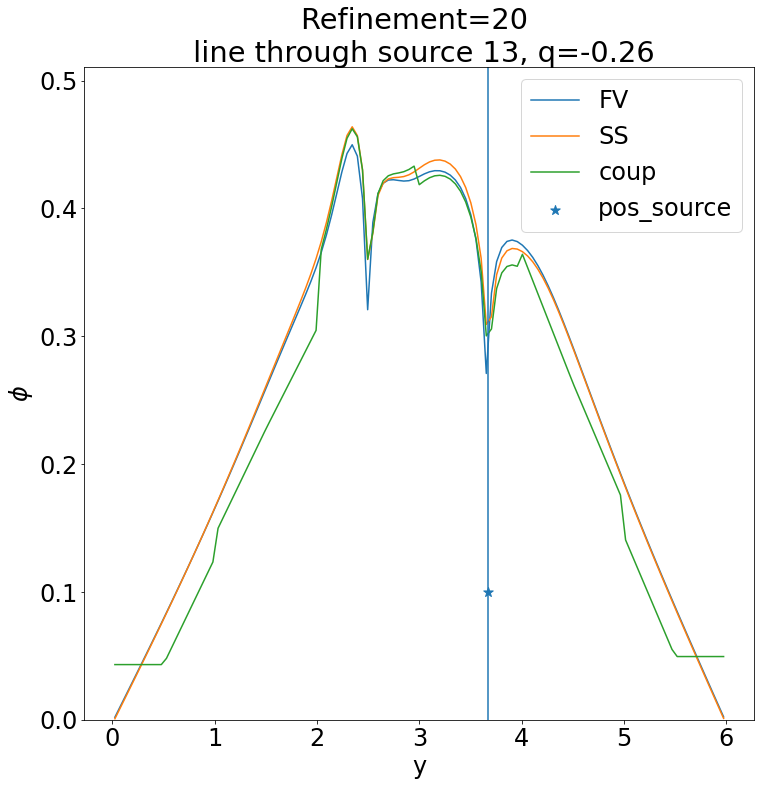

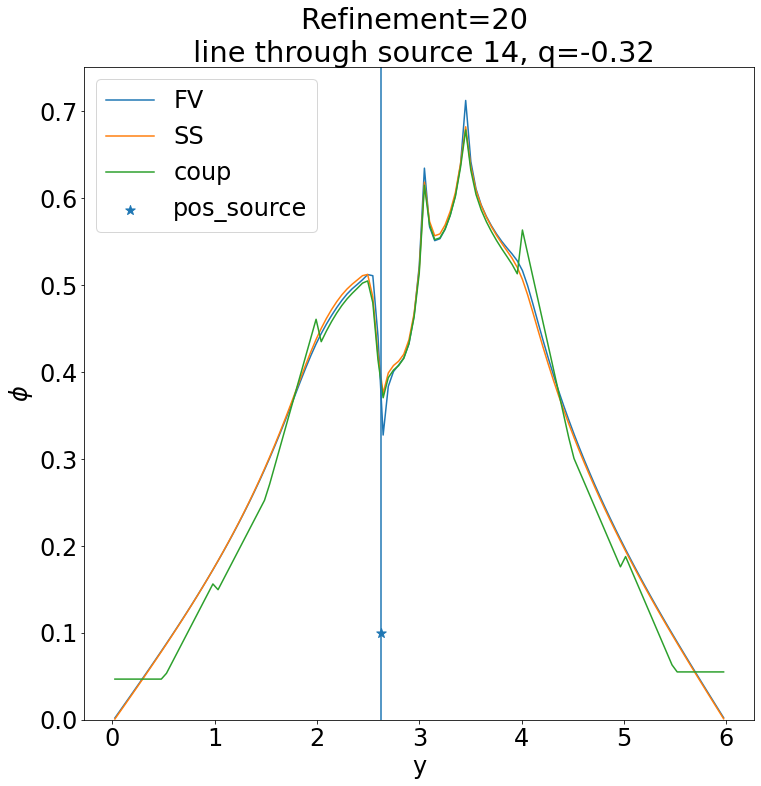

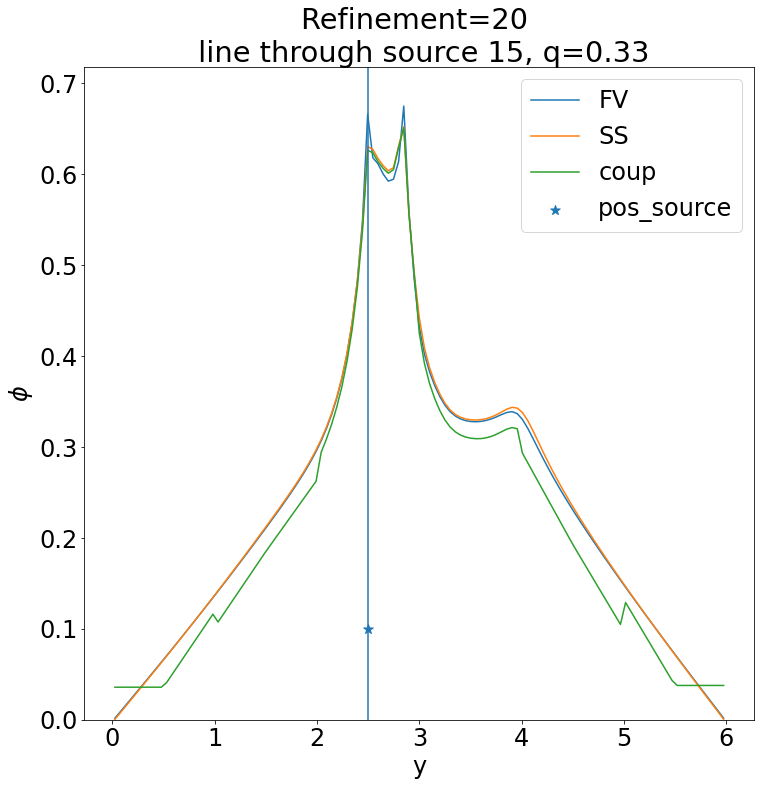

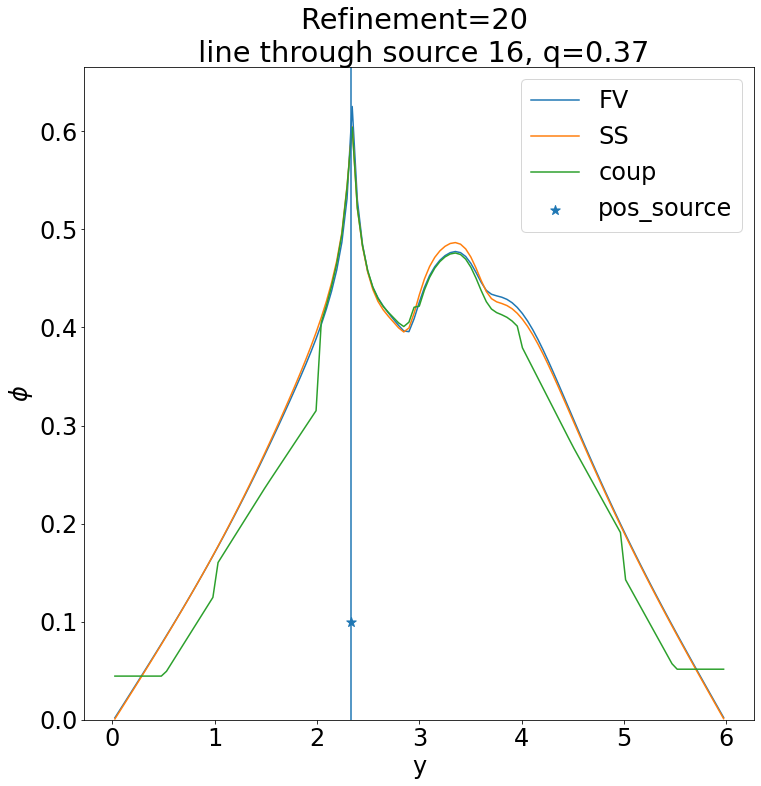

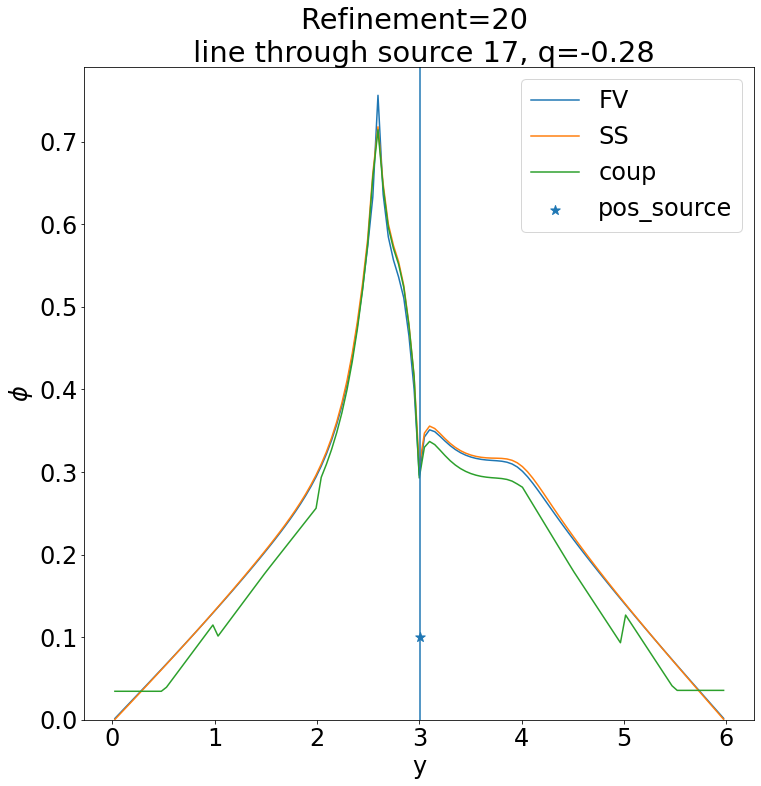

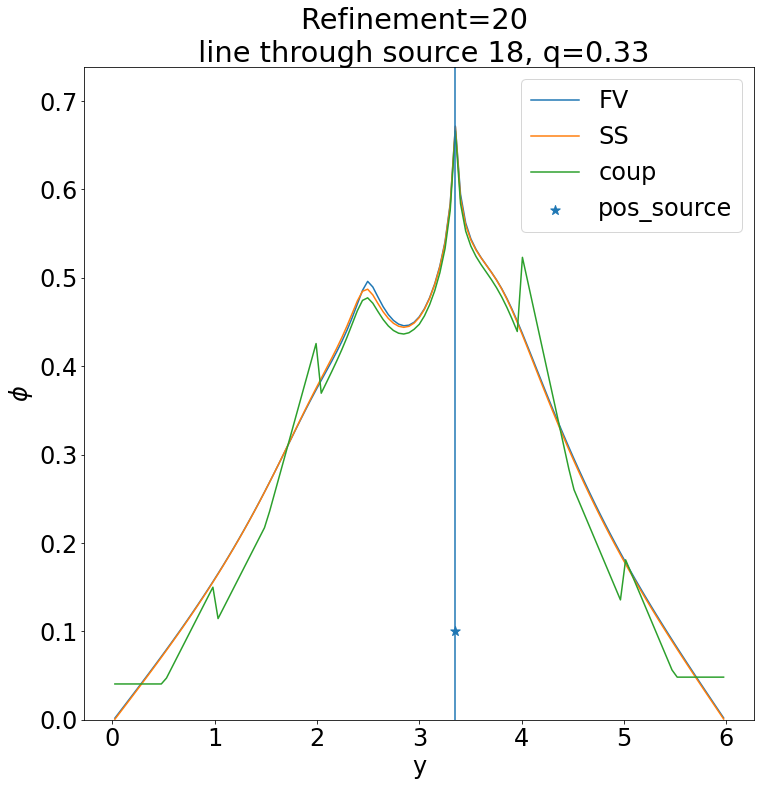

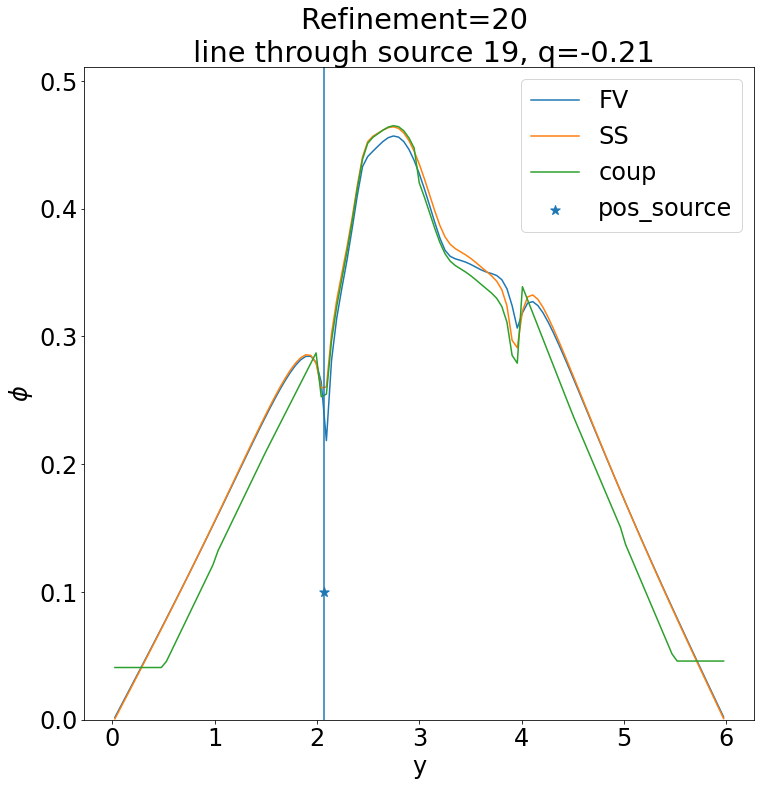

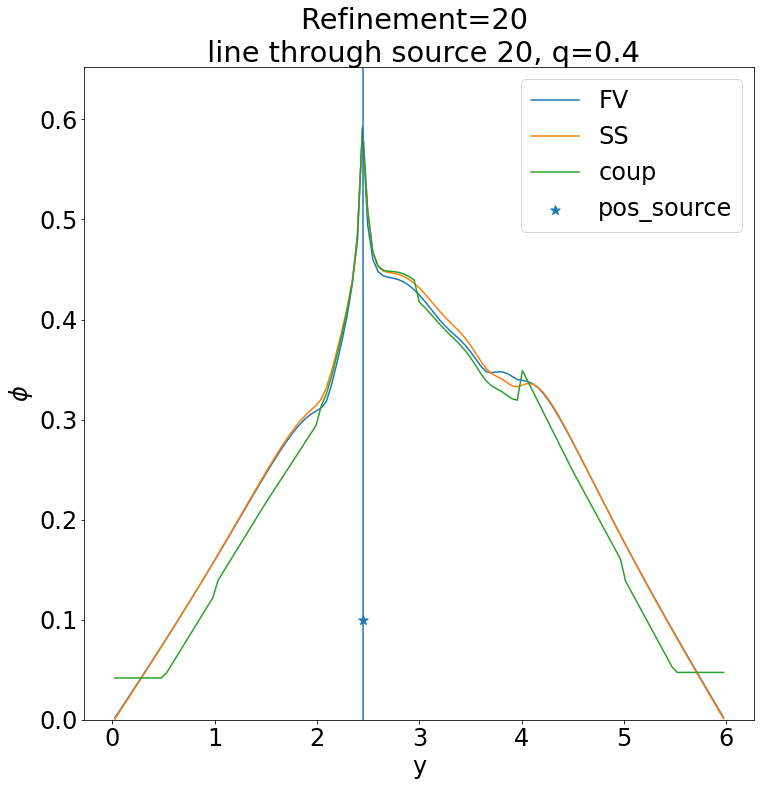

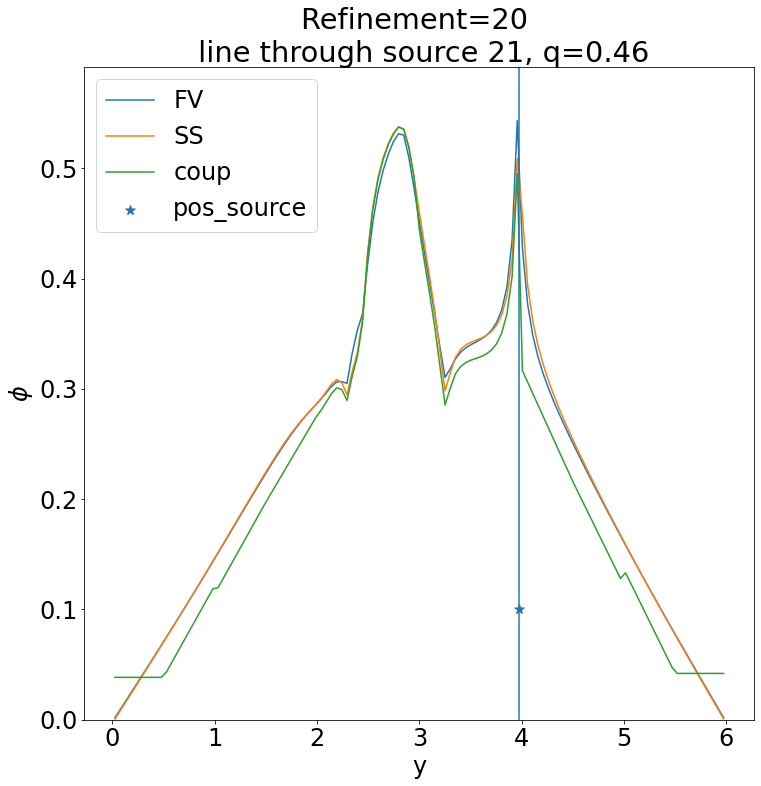

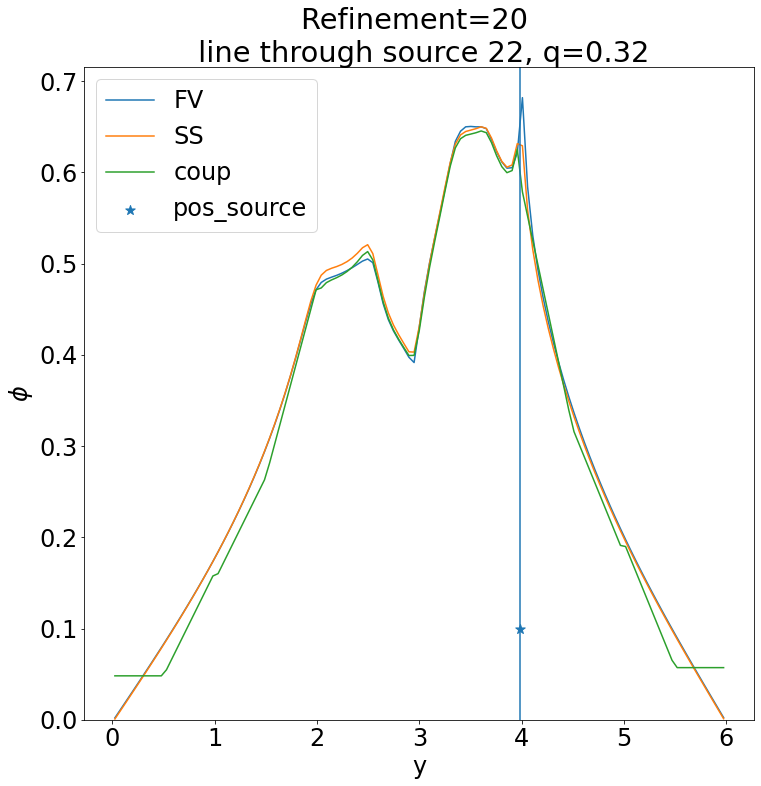

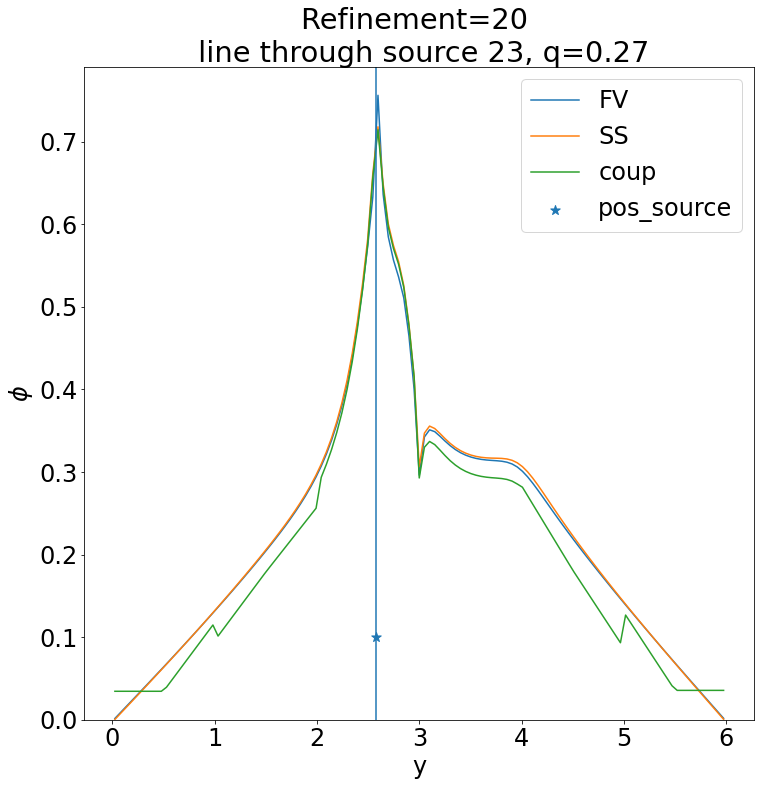

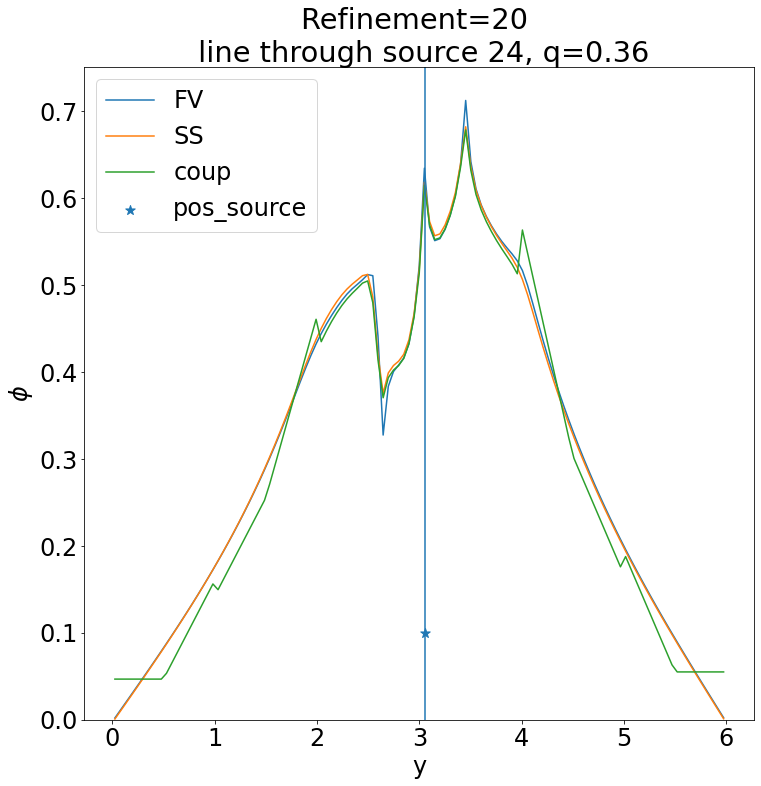

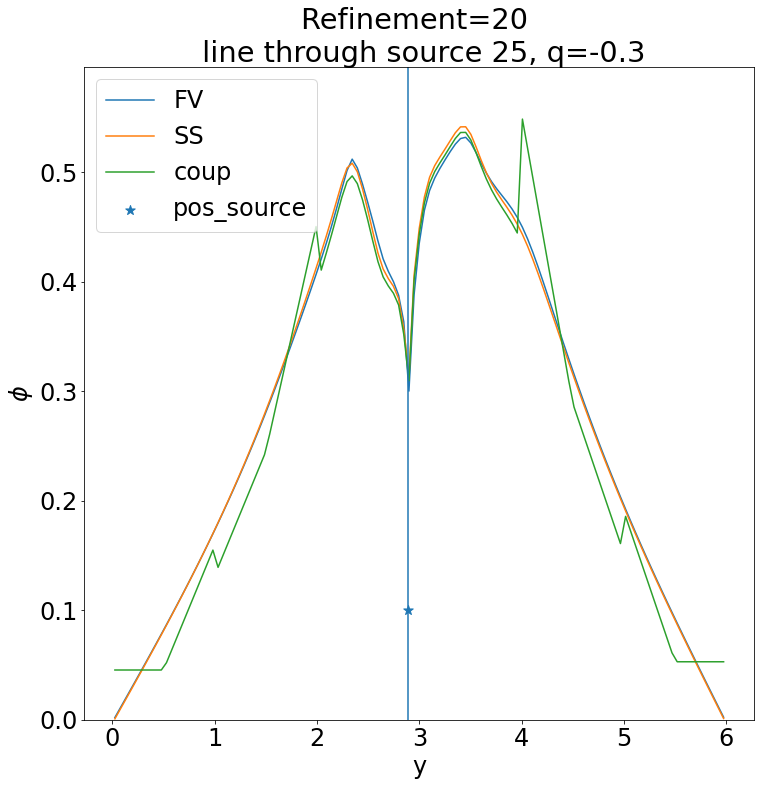

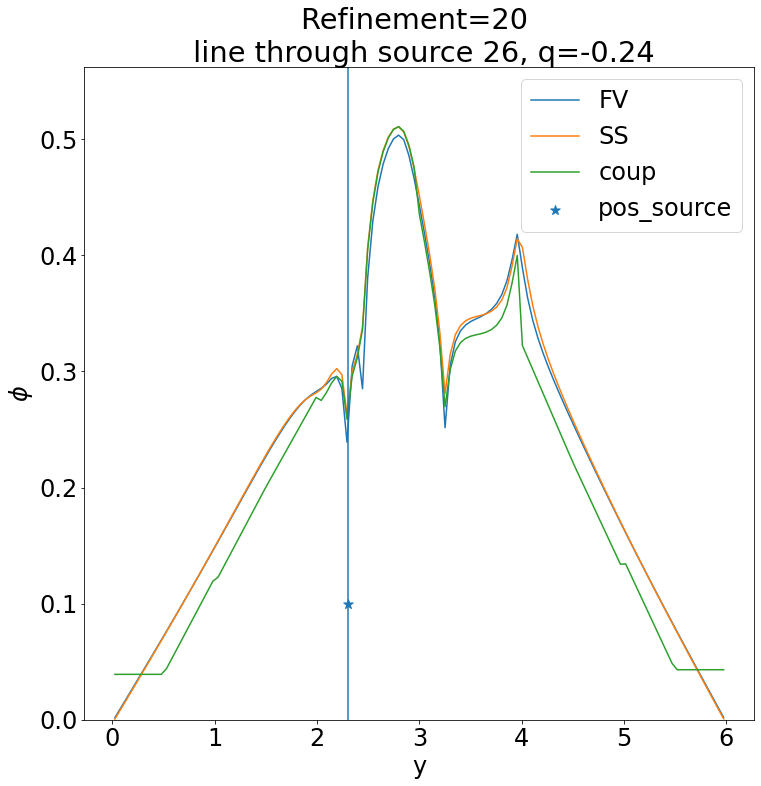

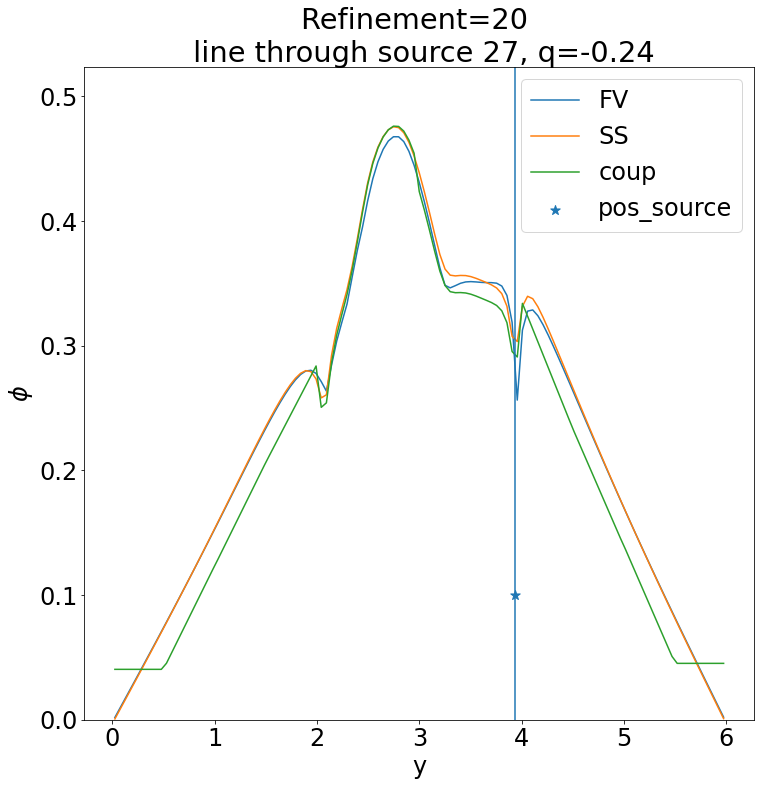

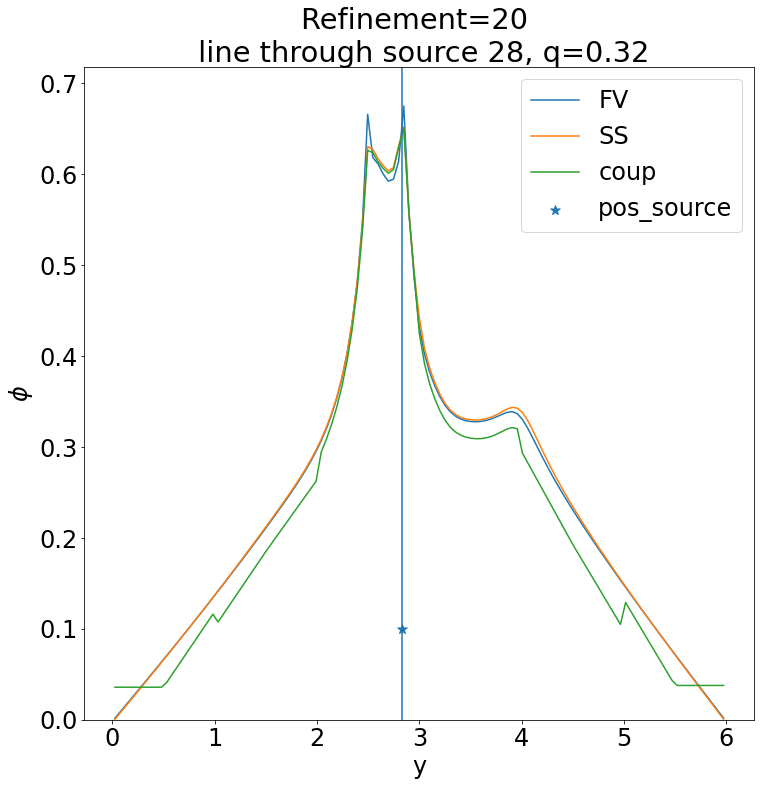

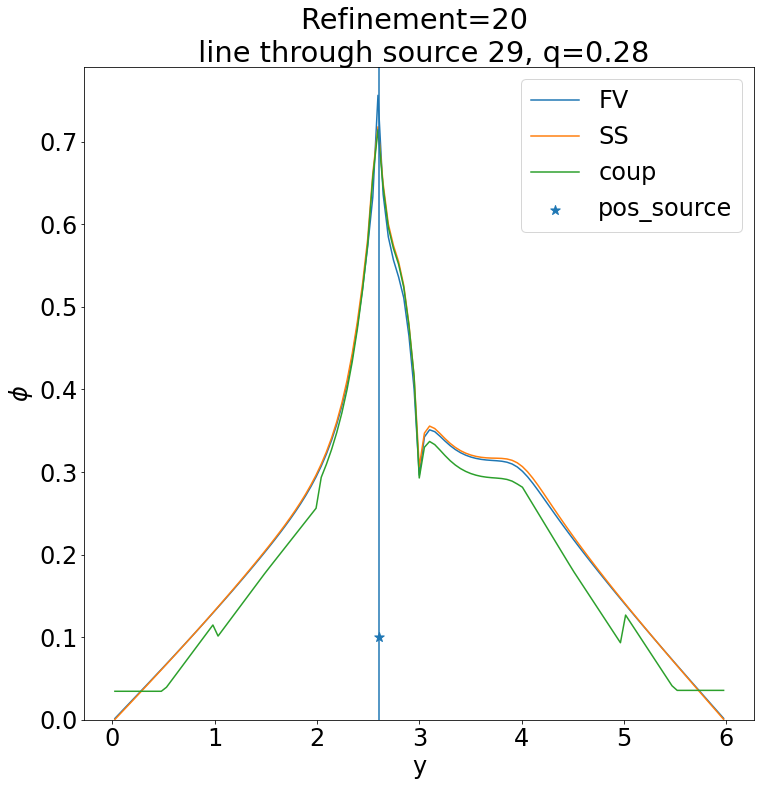

In [362]:
c=0
for i in array_of_rows:
    plt.figure()
    plt.plot(y_v, sol.reshape(ylen2,xlen2)[:,i], label="FV")
    plt.plot(y_v, SS[:,i], label="SS")
    plt.plot(y_v, rec[:,i], label="coup")
    plt.scatter(pos_s[c,1], np.array([0.1]),  label="pos_source",s=100, marker="*")
    plt.axvline(x=pos_s[c,1])
    plt.title("Refinement={} \n line through source {}, q={}".format(ratio,c, np.around(phi_q[c], decimals=2)))
    plt.ylabel("$\phi$")
    plt.xlabel("y")
    plt.ylim(0,1.1*np.max(SS[:,i]))
    plt.legend()
    c+=1

Let's try a lower density of sources and lower refinement

In [313]:
S=5
pos_s=np.random.random((S,2))*2+2

In [314]:
if real_Dirich:
    A=A_assembly(len(x_ss), len(y_ss))*D/h_ss**2
    #set dirichlet
    B,A=set_TPFA_Dirichlet(0,A, h_ss, get_boundary_vector(len(x_ss), len(y_ss)), np.zeros(len(x_ss)*len(y_ss)),D)
else:
    A=A_assembly_Dirich(len(x_ss), len(y_ss))*D/h_ss**2
    B=np.zeros(A.shape[0])

In [315]:
t=assemble_SS_2D_FD(pos_s, A, Rv, h_ss,x_ss,y_ss, K_eff, D,1)
t.pos_arrays()
t.initialize_matrices()
t.assembly_sol_split_problem()
B_v=np.zeros(len(t.uni_s_blocks))


In [316]:
B_q=np.ones(len(t.s_blocks))
B_q[np.random.randint(S-1, size=S//2)]=0
B=np.concatenate((B,B_v,B_q))

In [317]:
phi=np.linalg.solve(t.M, B)
phi_FV, phi_v, phi_q=post.separate_unk(t, phi)
phi_mat=phi_FV.reshape(len(x_ss), len(y_ss))

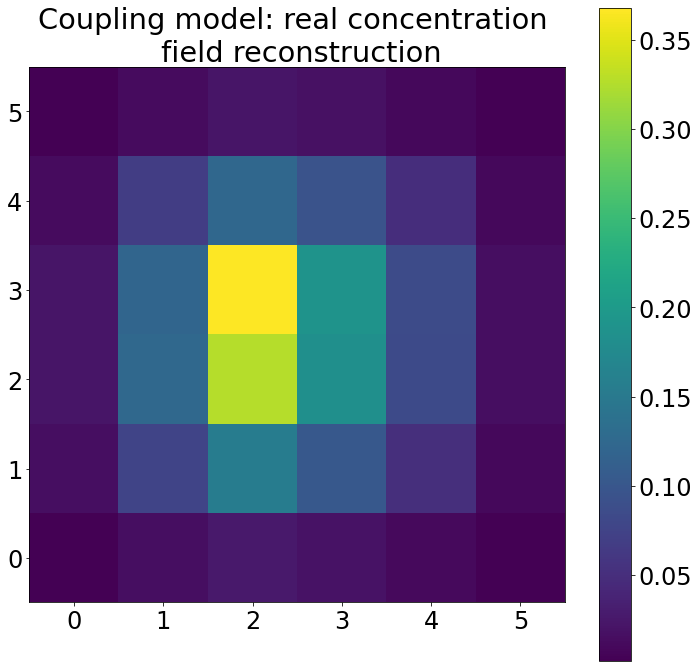

In [318]:
plt.imshow(phi_mat, origin="lower"); plt.colorbar()
plt.title("Coupling model: real concentration \n field reconstruction")
plt.show()

In [319]:
ratio=15

In [320]:
o=post.reconstruct_coupling(phi, 1, t,1)
rec=o.reconstruction(ratio)

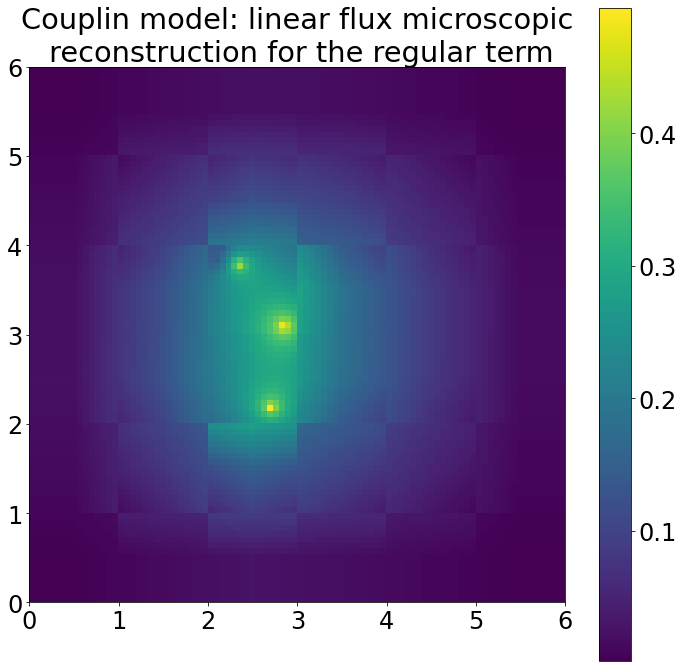

In [321]:

plt.imshow(rec, extent=[0,L,0,L], origin='lower')
plt.title("Couplin model: linear flux microscopic\n reconstruction for the regular term")
plt.colorbar()
plt.show()
    

In [322]:
sol, xlen2, ylen2,q_array,aa, Y, s_b,x_v, y_v=get_validation(ratio, t, pos_s, B_q, D, K_eff, Rv,L)


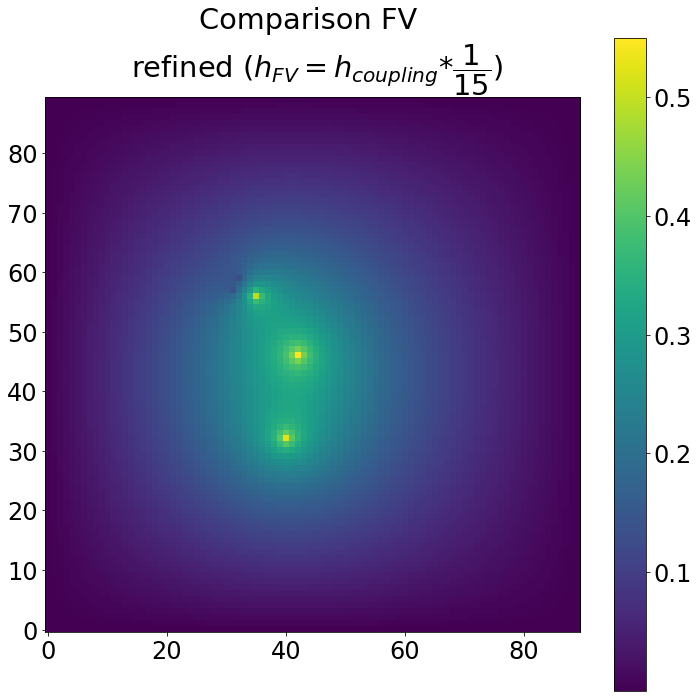

In [323]:
plt.imshow(sol.reshape(ylen2, xlen2), origin='lower'); plt.colorbar()
title_string="Comparison FV \n refined ($h_{FV}=h_{coupling}$" + "*$\dfrac{1}{%d}$)" % ratio
plt.title(title_string)
plt.show()

[ 0.46238997  0.44278417 -0.1241716  -0.14233517  0.50375876]


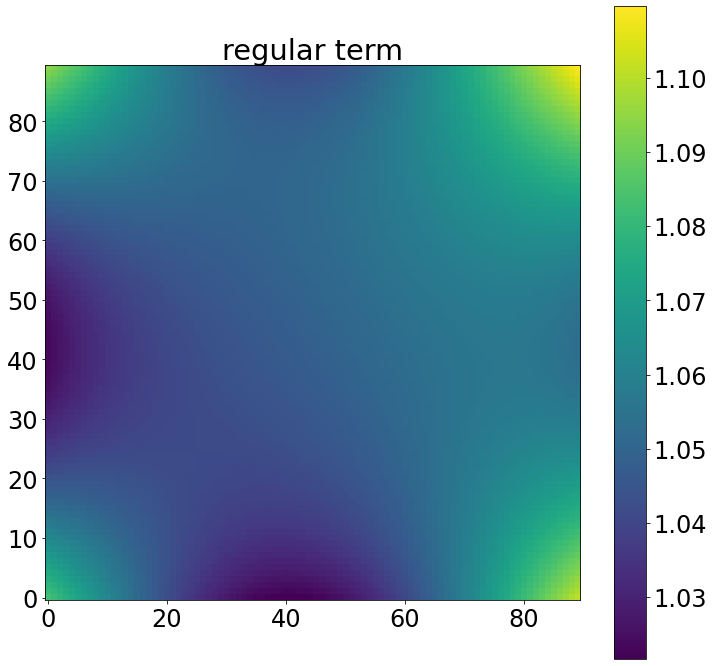

In [324]:
a=full_ss(pos_s, Rv, h_ss/ratio, K_eff, D,L)
SS=a.solve_problem(B_q)
SS=a.reconstruct(a.v, a.phi_q)
plt.show()

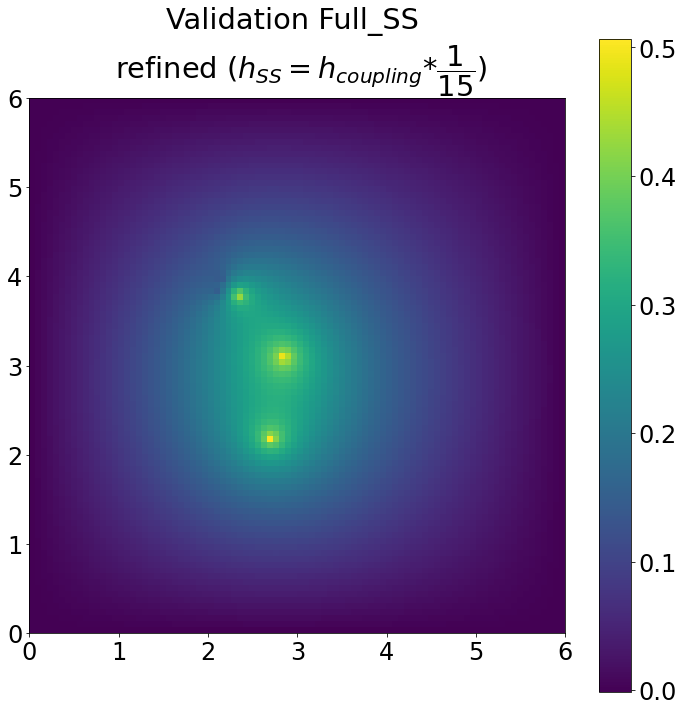

In [325]:

plt.imshow(SS, origin="lower", extent=[0,L,0,L]); plt.colorbar()
title_string="Validation Full_SS \n refined ($h_{SS}=h_{coupling}$" + "*$\dfrac{1}{%d}$)" % ratio
plt.title(title_string)
plt.show()
#reconstruct the full solution splitting
a.uni_s_blocks=np.array([])
a.s_blocks=np.array([])
a.FV_DoF=np.arange(len(a.v))

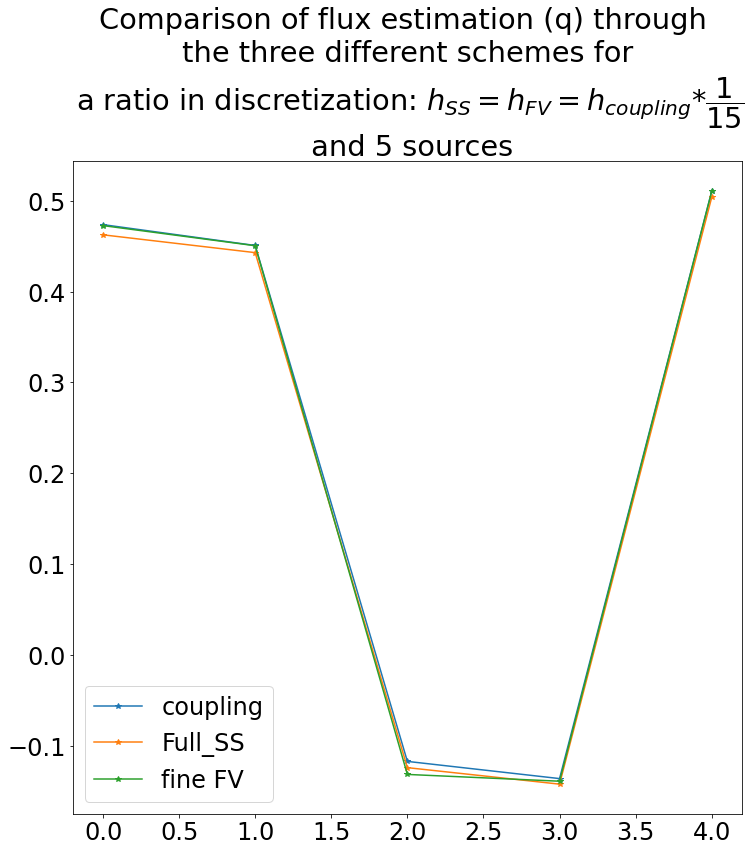

In [326]:
plt.figure()
title_string="Comparison of flux estimation (q) through \n the three different schemes for \n a ratio in \
discretization: $h_{SS}=h_{FV}=h_{coupling}$" + "*$\dfrac{1}{%d}$ \n and %d sources" % (ratio, S)
plt.plot(phi_q, label="coupling", marker='*')
plt.plot(a.phi_q, label="Full_SS",marker='*')
plt.plot(q_array, label="fine FV",marker='*')
plt.title(title_string)
plt.legend()


<Figure size 864x864 with 0 Axes>

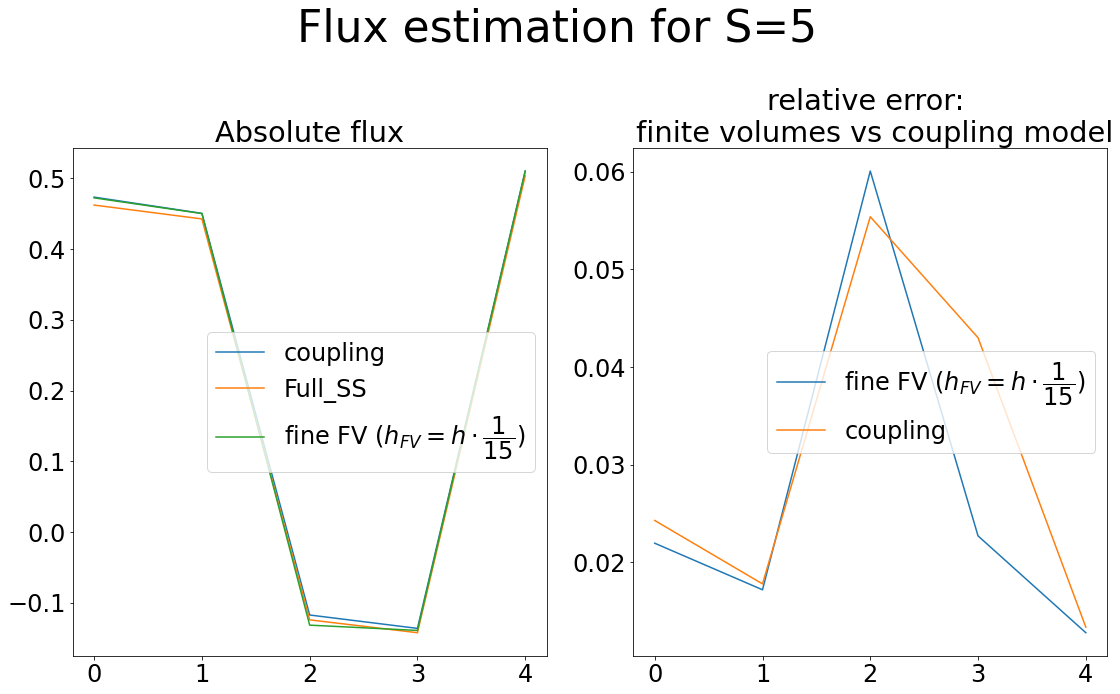

In [327]:
#error plots
error_fv=(q_array-a.phi_q)/a.phi_q
error_coup=(phi_q-a.phi_q)/a.phi_q
plt.figure(figsize=(12,12))


fig, axs=plt.subplots(1,2, figsize=(16,10))
fig.suptitle("Flux estimation for S={}".format(S), fontsize=44)
im=axs[0].plot(np.arange(S),phi_q, label="coupling")
im=axs[0].plot(np.arange(S),a.phi_q, label="Full_SS")
im=axs[0].plot(np.arange(S),q_array, label="fine FV ($h_{FV}=h\cdot\dfrac{1}{%d}$)" % ratio)
axs[0].legend()
axs[0].set_title("Absolute flux")
im=axs[1].plot(np.arange(S),np.abs(error_fv), label="fine FV ($h_{FV}=h\cdot\dfrac{1}{%d}$)" % ratio)
im=axs[1].plot(np.arange(S),np.abs(error_coup), label="coupling")
axs[1].set_title("relative error: \n finite volumes vs coupling model")
fig.tight_layout() 
plt.legend()

In [328]:
get_L2(a.phi_q, q_array, "FV", ratio)
get_L2(a.phi_q, phi_q, "coupling", 1)

L^2 norm for the FV with 15 refinement= 0.01639267446216995
L^2 norm for the coupling with 1 refinement= 0.017843893439512714


The advantage of the coupling model is not the increase in accuracy when discretizing finer. The advantage lies in the control over the neighbourhood consider and the increase of accuracy when increased the size of the neighbourhood

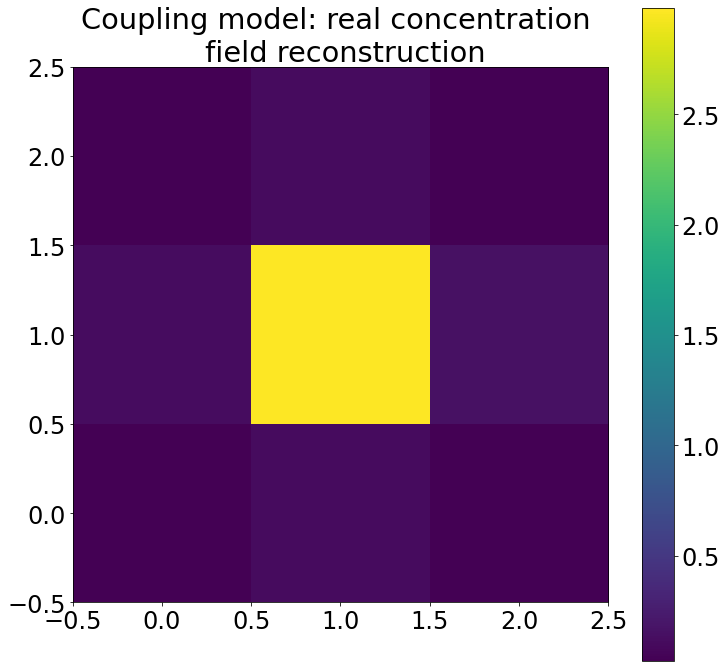

In [329]:
#1-Set up the domain
D=1
L=6
h_ss=2
#Rv=np.exp(-2*np.pi)*h_ss
Rv=0.01
C0=1
K_eff=1/(np.pi*Rv**2)

validation=False
real_Dirich=True
x_ss=np.linspace(h_ss/2, L-h_ss/2, int(L//h_ss))
y_ss=x_ss

S=30
pos_s=np.random.random((S,2))*2+2

if real_Dirich:
    A=A_assembly(len(x_ss), len(y_ss))*D/h_ss**2
    #set dirichlet
    B,A=set_TPFA_Dirichlet(0,A, h_ss, get_boundary_vector(len(x_ss), len(y_ss)), np.zeros(len(x_ss)*len(y_ss)),D)
else:
    A=A_assembly_Dirich(len(x_ss), len(y_ss))*D/h_ss**2
    B=np.zeros(A.shape[0])
    
t=assemble_SS_2D_FD(pos_s, A, Rv, h_ss,x_ss,y_ss, K_eff, D,1)
t.pos_arrays()
t.initialize_matrices()
t.assembly_sol_split_problem()
B_v=np.zeros(len(t.uni_s_blocks))

B_q=np.ones(len(t.s_blocks))
B_q[np.random.randint(S-1, size=S//2)]=0
B=np.concatenate((B,B_v,B_q))

phi=np.linalg.solve(t.M, B)
phi_FV, phi_v, phi_q=post.separate_unk(t, phi)
phi_mat=phi_FV.reshape(len(x_ss), len(y_ss))

plt.imshow(phi_mat, origin="lower"); plt.colorbar()
plt.title("Coupling model: real concentration \n field reconstruction")
plt.show()

[-0.31227263  0.36309759  0.2995026  -0.34144864  0.2963186   0.36316176
  0.35579495  0.38193601  0.32684035 -0.26923847 -0.39580551  0.49655374
 -0.31881051  0.37325915  0.40438556 -0.24526301  0.32602093  0.40139457
 -0.31686694  0.36084931 -0.28481861 -0.2445566  -0.28425573  0.27580433
  0.27180208 -0.32889219 -0.45105546  0.3421662   0.31752576  0.37019914]


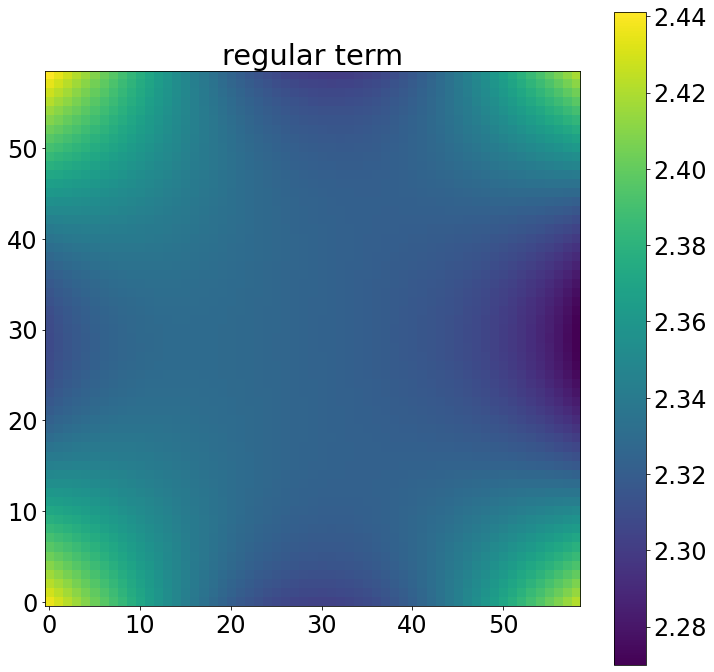

In [330]:
ratio=20

a=full_ss(pos_s, Rv, h_ss/ratio, K_eff, D,L)
SS=a.solve_problem(B_q)
SS=a.reconstruct(a.v, a.phi_q)
plt.show()

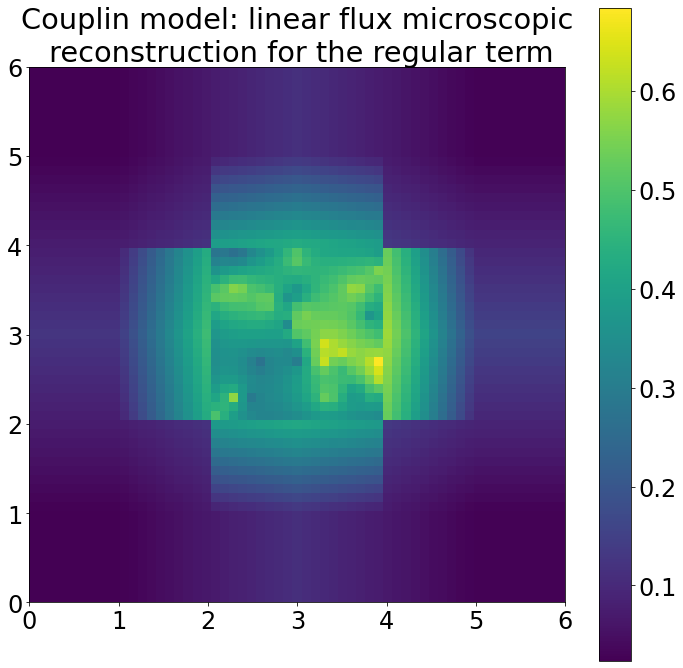

In [331]:
o=post.reconstruct_coupling(phi, 1, t,1)
rec=o.reconstruction(ratio)
plt.imshow(rec, extent=[0,L,0,L], origin='lower')
plt.title("Couplin model: linear flux microscopic\n reconstruction for the regular term")
plt.colorbar()
plt.show()

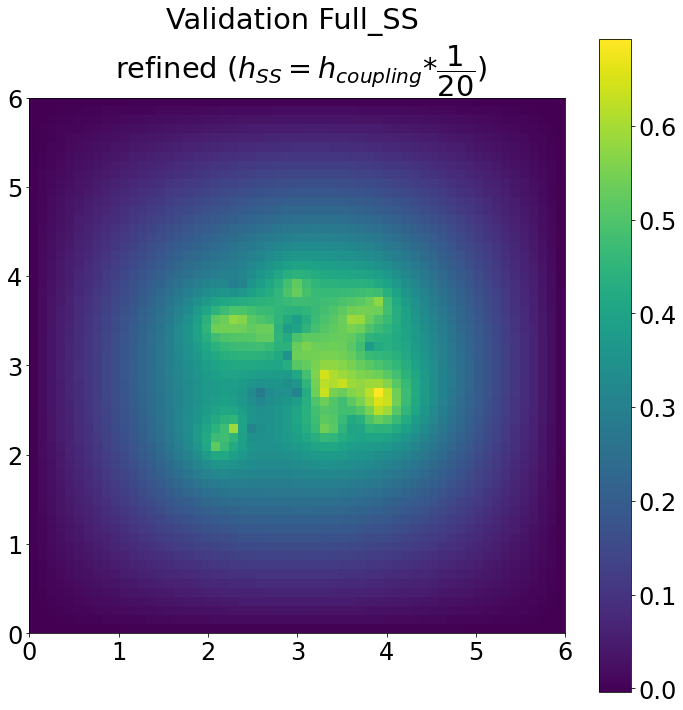

In [332]:

plt.imshow(SS, origin="lower", extent=[0,L,0,L]); plt.colorbar()
title_string="Validation Full_SS \n refined ($h_{SS}=h_{coupling}$" + "*$\dfrac{1}{%d}$)" % ratio
plt.title(title_string)
plt.show()
#reconstruct the full solution splitting
a.uni_s_blocks=np.array([])
a.s_blocks=np.array([])
a.FV_DoF=np.arange(len(a.v))


    

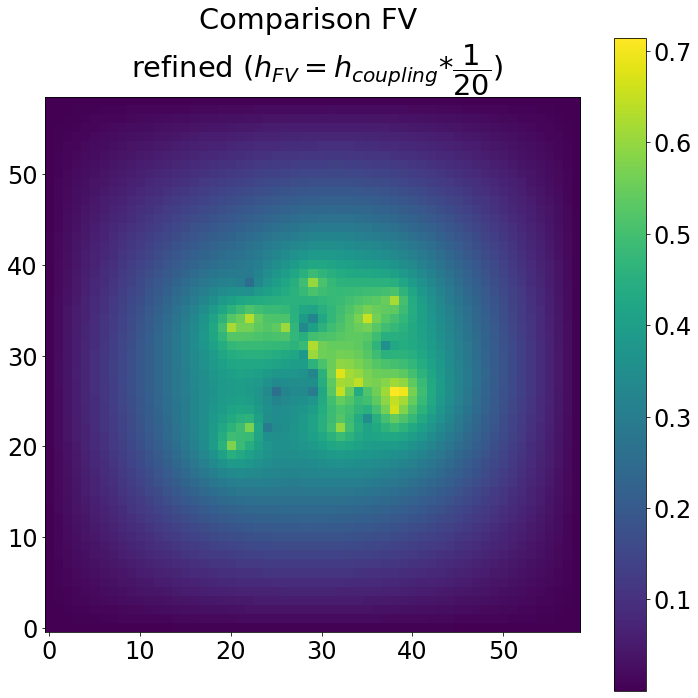

In [333]:
sol, xlen2, ylen2,q_array,aa, Y, s_b,x_v, y_v=get_validation(ratio, t, pos_s, B_q, D, K_eff, Rv,L)
plt.imshow(sol.reshape(ylen2, xlen2), origin='lower'); plt.colorbar()
title_string="Comparison FV \n refined ($h_{FV}=h_{coupling}$" + "*$\dfrac{1}{%d}$)" % ratio
plt.title(title_string)
plt.show()

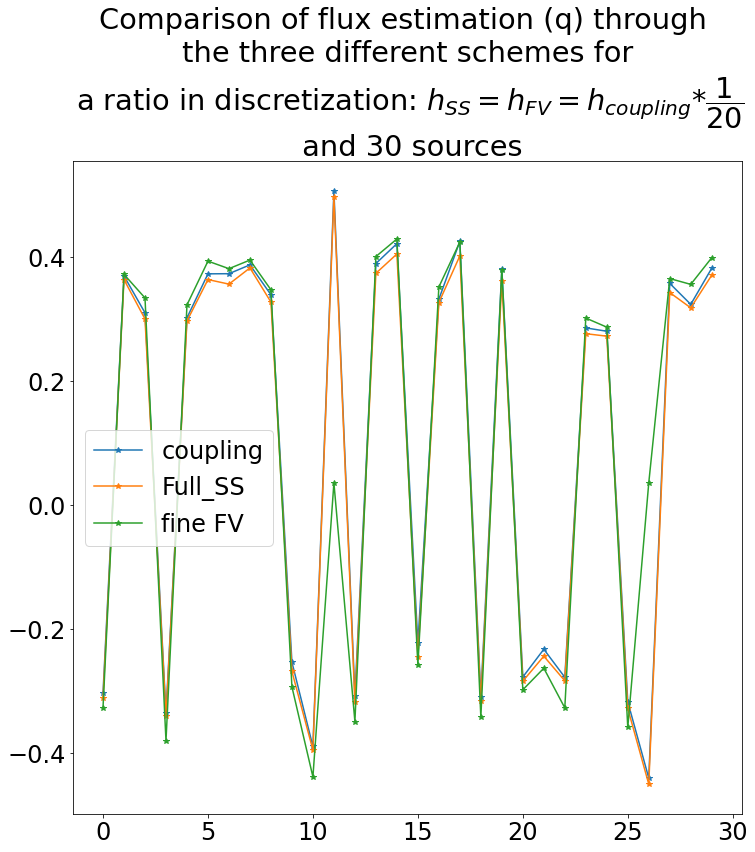

In [334]:
plt.figure()
title_string="Comparison of flux estimation (q) through \n the three different schemes for \n a ratio in \
discretization: $h_{SS}=h_{FV}=h_{coupling}$" + "*$\dfrac{1}{%d}$ \n and %d sources" % (ratio, S)
plt.plot(phi_q, label="coupling", marker='*')
plt.plot(a.phi_q, label="Full_SS",marker='*')
plt.plot(q_array, label="fine FV",marker='*')
plt.title(title_string)
plt.legend()

<Figure size 864x864 with 0 Axes>

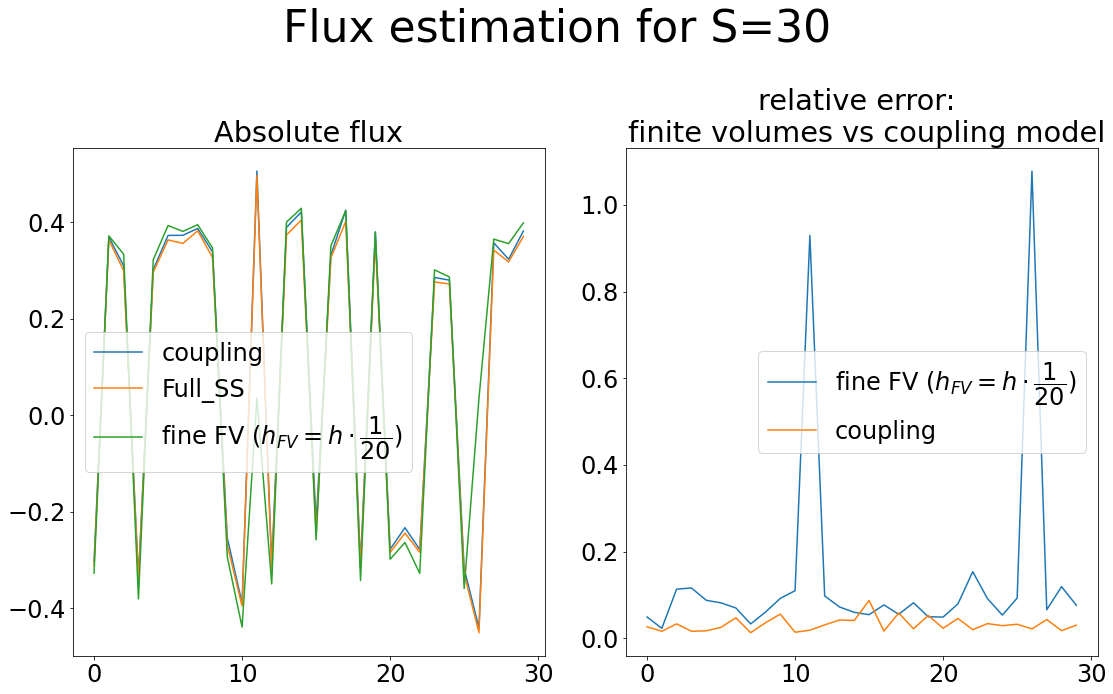

In [335]:
#error plots
error_fv=(q_array-a.phi_q)/a.phi_q
error_coup=(phi_q-a.phi_q)/a.phi_q
plt.figure(figsize=(12,12))


fig, axs=plt.subplots(1,2, figsize=(16,10))
fig.suptitle("Flux estimation for S={}".format(S), fontsize=44)
im=axs[0].plot(np.arange(S),phi_q, label="coupling")
im=axs[0].plot(np.arange(S),a.phi_q, label="Full_SS")
im=axs[0].plot(np.arange(S),q_array, label="fine FV ($h_{FV}=h\cdot\dfrac{1}{%d}$)" % ratio)
axs[0].legend()
axs[0].set_title("Absolute flux")
im=axs[1].plot(np.arange(S),np.abs(error_fv), label="fine FV ($h_{FV}=h\cdot\dfrac{1}{%d}$)" % ratio)
im=axs[1].plot(np.arange(S),np.abs(error_coup), label="coupling")
axs[1].set_title("relative error: \n finite volumes vs coupling model")
fig.tight_layout() 
plt.legend()

In [336]:
get_L2(a.phi_q, q_array, "FV", ratio)
get_L2(a.phi_q, phi_q, "coupling", 1)

L^2 norm for the FV with 20 refinement= 0.6849502392259361
L^2 norm for the coupling with 1 refinement= 0.06444085419428154


For the opposite case where the FV perform best and the coupling performs worst:
Low density of sources conserving the neighbourhood and refining the coupling

D=1, L=6, h_ss=0.5, ratio=10, #ofSources=10, Rv=0.01, K_eff=3183.098861837907


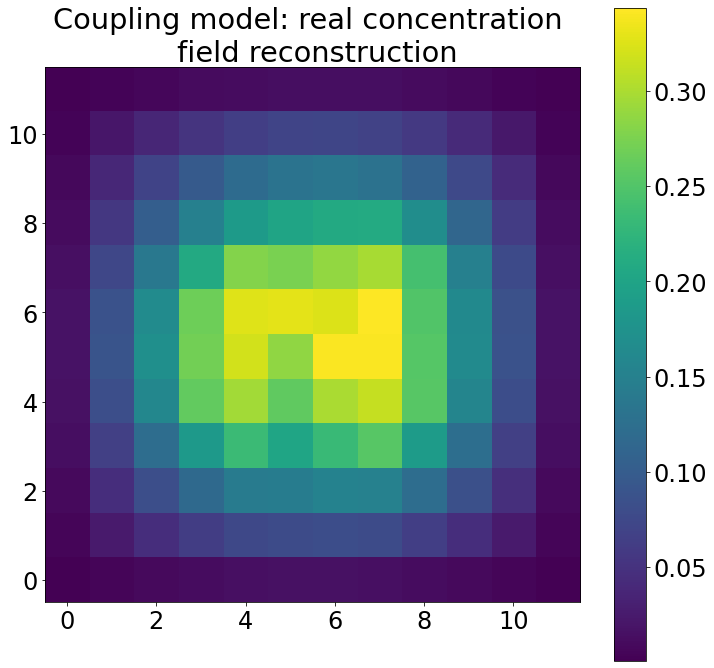

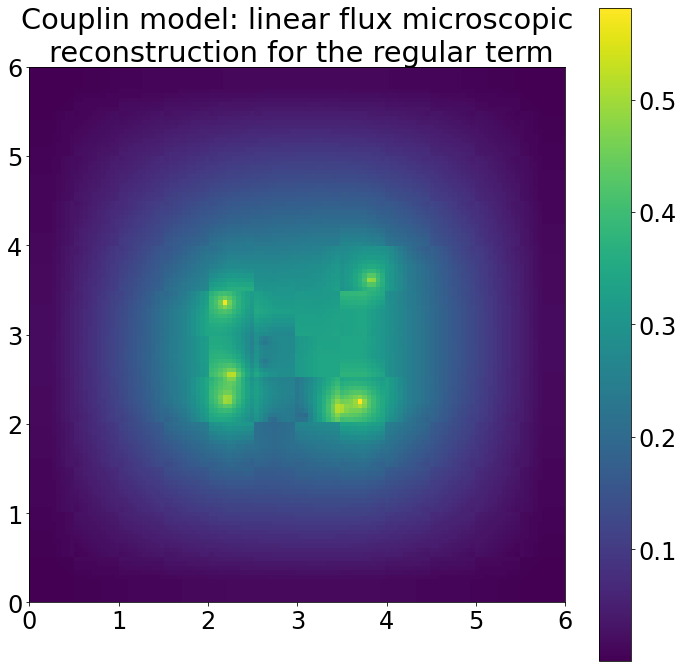

[-0.16920204  0.45069406 -0.19086397  0.4132529   0.42035718 -0.19901239
  0.40146549 -0.18554894  0.44410599  0.40724748]


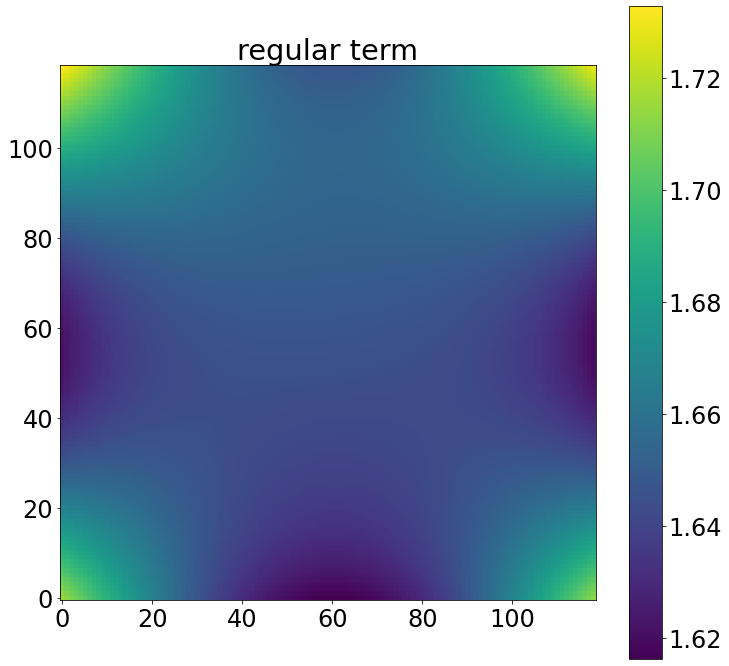

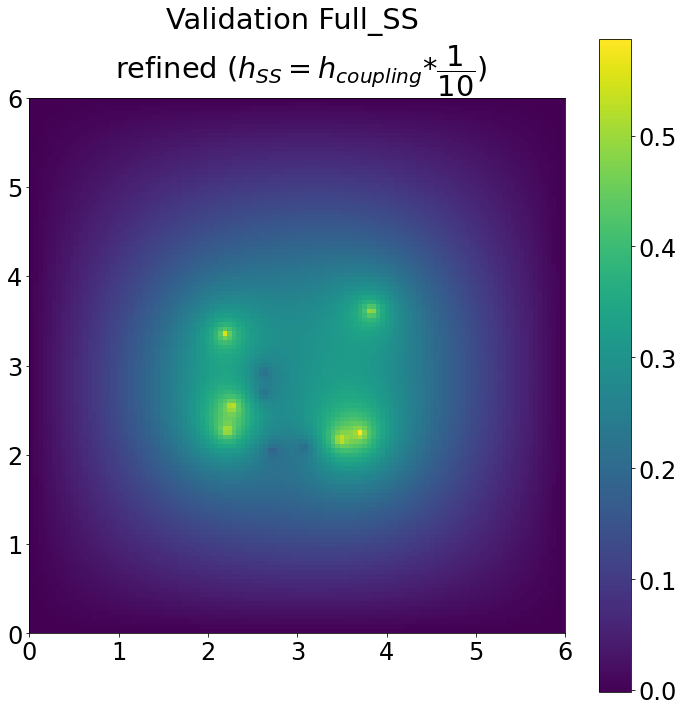

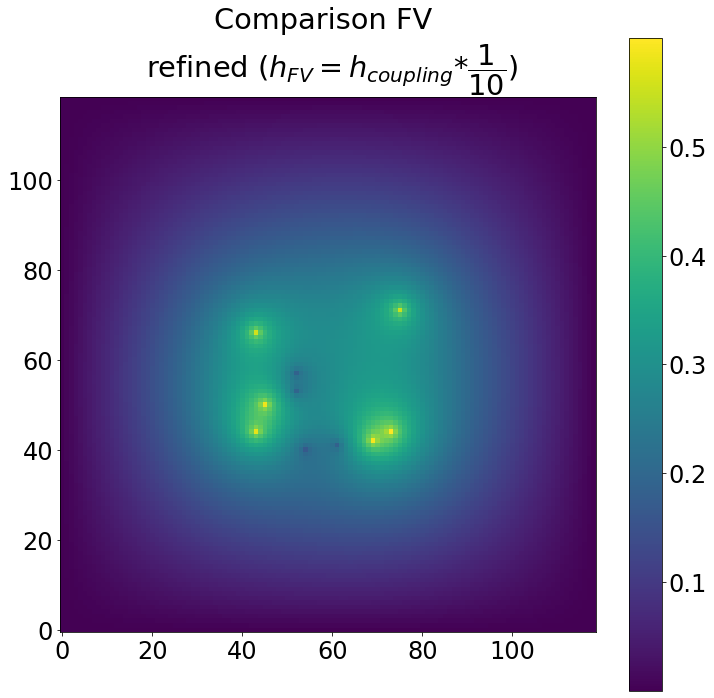

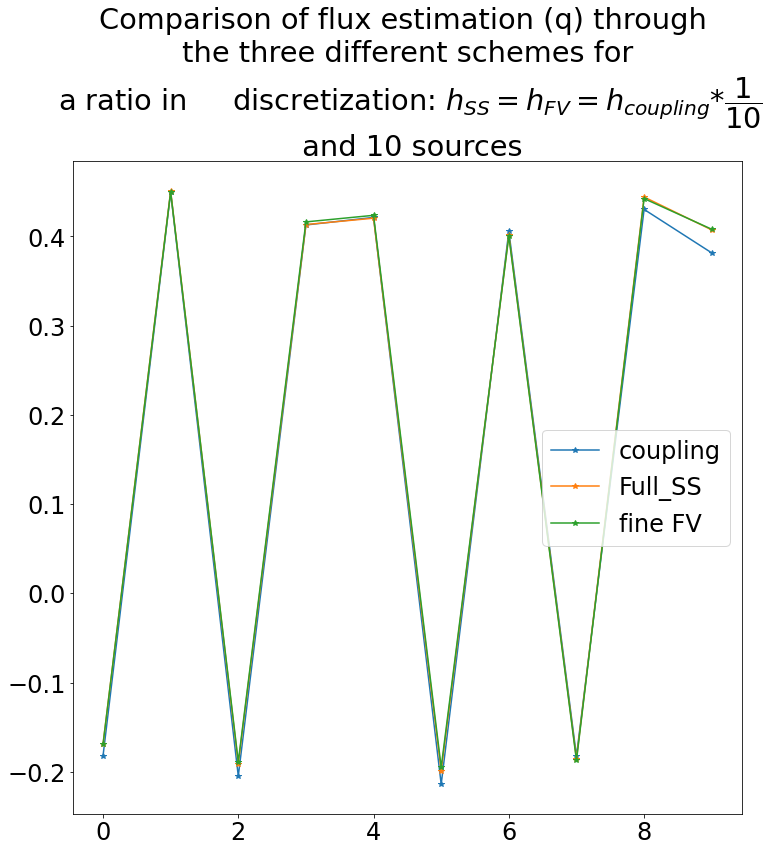

<Figure size 864x864 with 0 Axes>

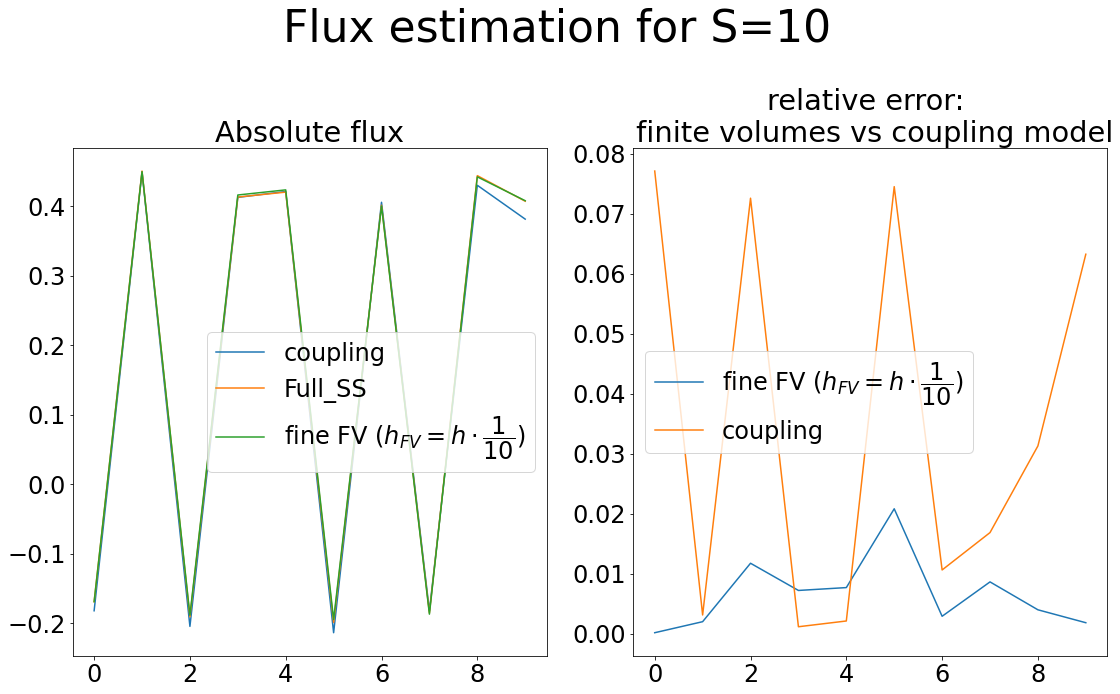

L^2 norm for the FV with 10 refinement= 0.007052367244599166
L^2 norm for the coupling with 1 refinement= 0.03834287024064973


In [337]:
execute_full_problem(0.5,10,10)

D=1, L=6, h_ss=0.5, ratio=10, #ofSources=30, Rv=0.01, K_eff=3183.098861837907


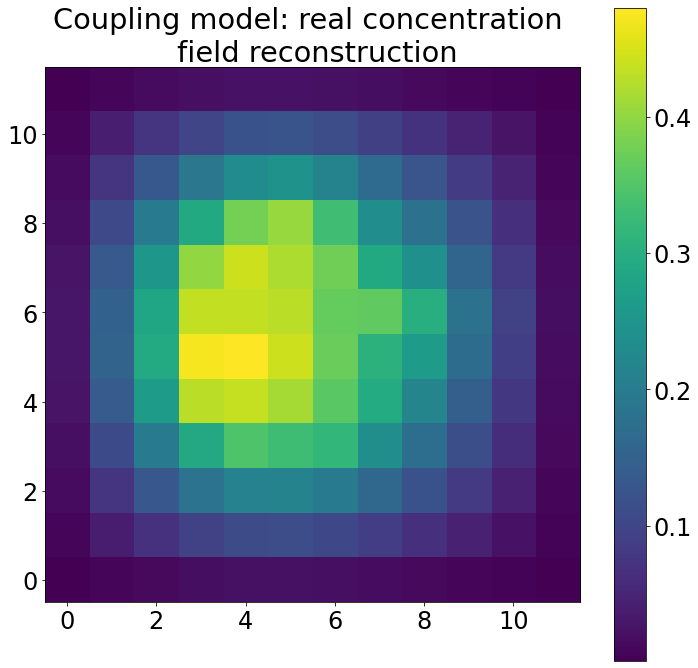

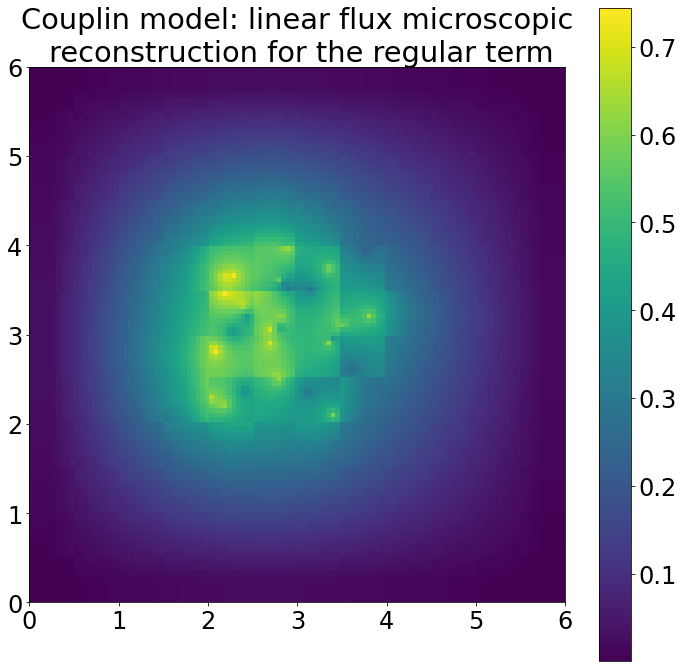

[-0.36799262 -0.42169946  0.33755529 -0.30464623  0.41235842 -0.33978346
 -0.30993487 -0.37449033 -0.2062753   0.37103192  0.29960617  0.4197573
  0.37818909  0.26055703  0.35024124 -0.37072076 -0.25474654 -0.38780201
  0.33067691  0.39376473 -0.29053271  0.25239851  0.33569683  0.26358676
  0.35256705  0.29259836  0.31160462  0.32047191  0.26109393  0.25543359]


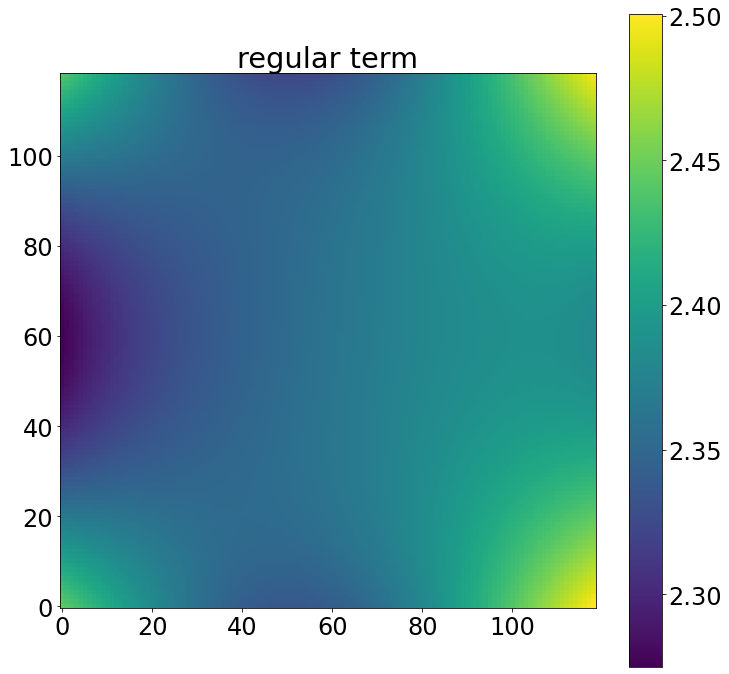

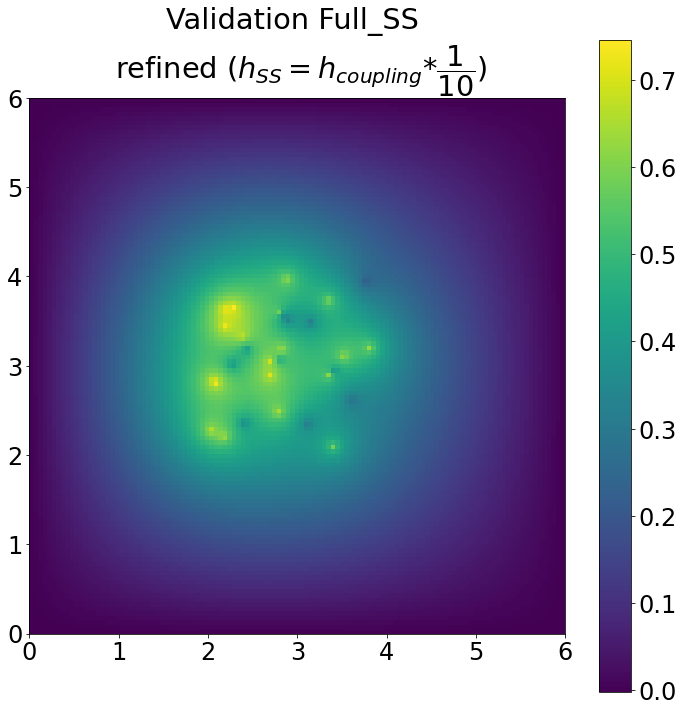

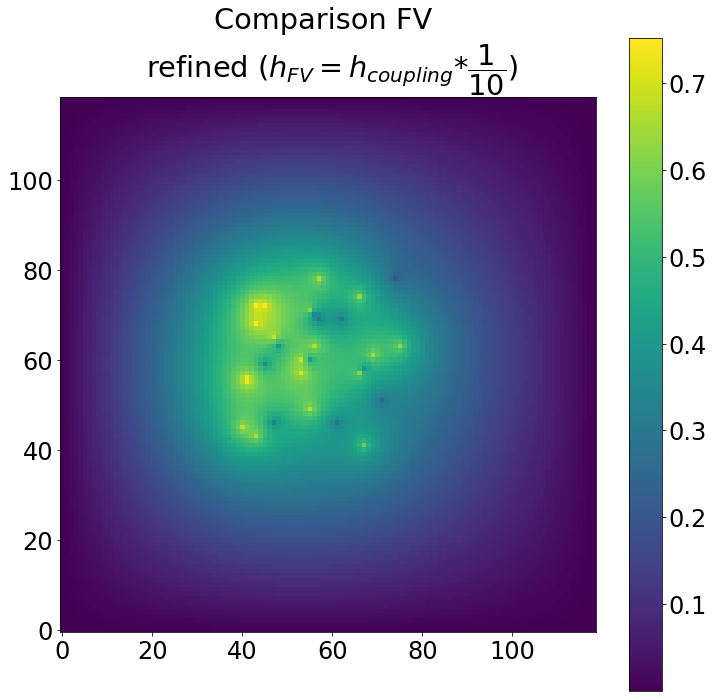

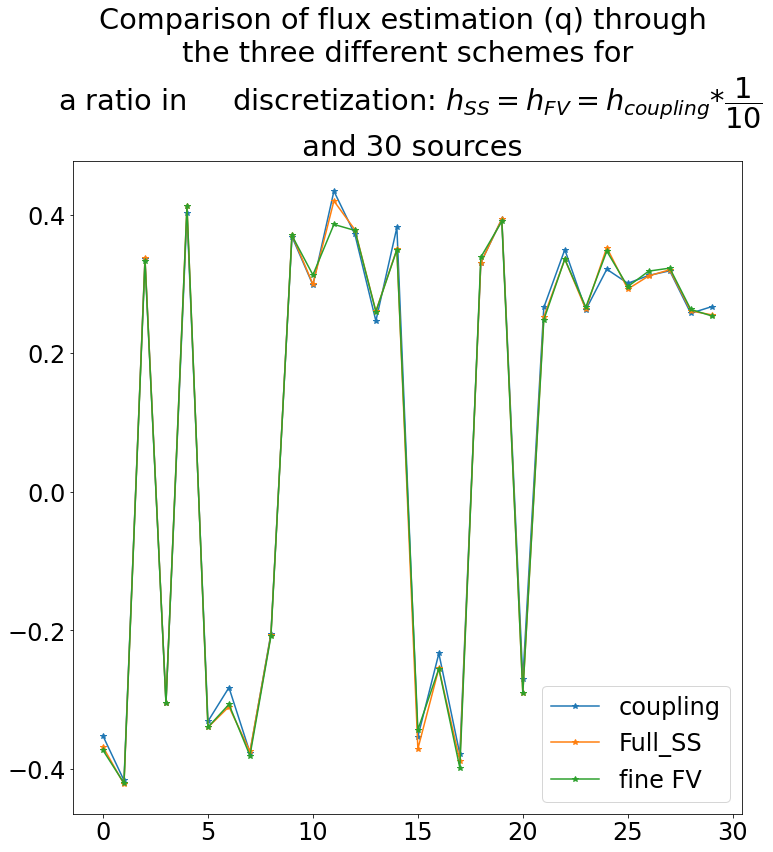

<Figure size 864x864 with 0 Axes>

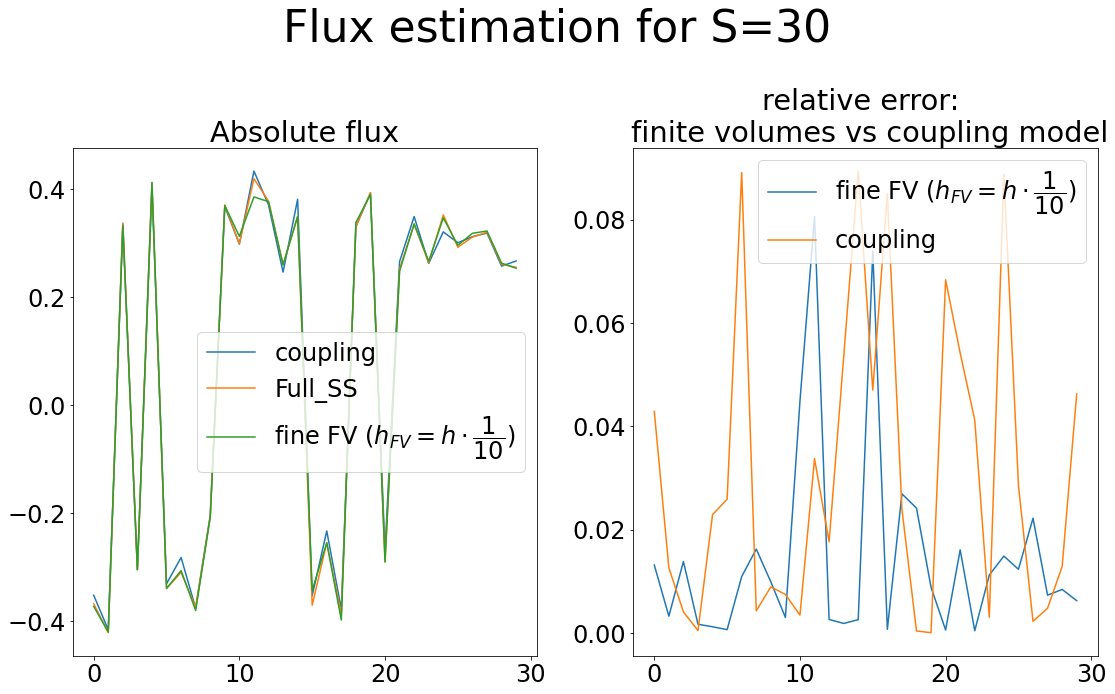

L^2 norm for the FV with 10 refinement= 0.049911092020290065
L^2 norm for the coupling with 1 refinement= 0.07404277606097558


In [338]:
execute_full_problem(0.5,10,30)

D=1, L=6, h_ss=2, ratio=20, #ofSources=3, Rv=0.01, K_eff=3183.098861837907


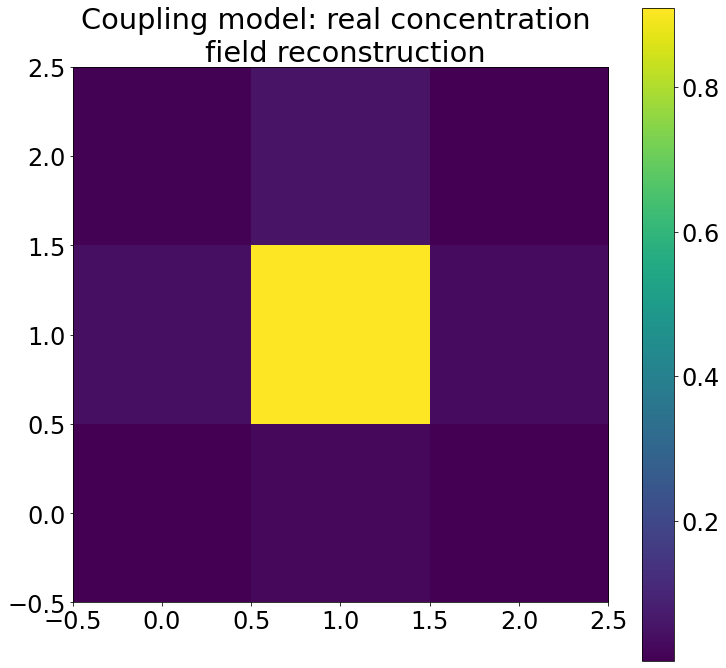

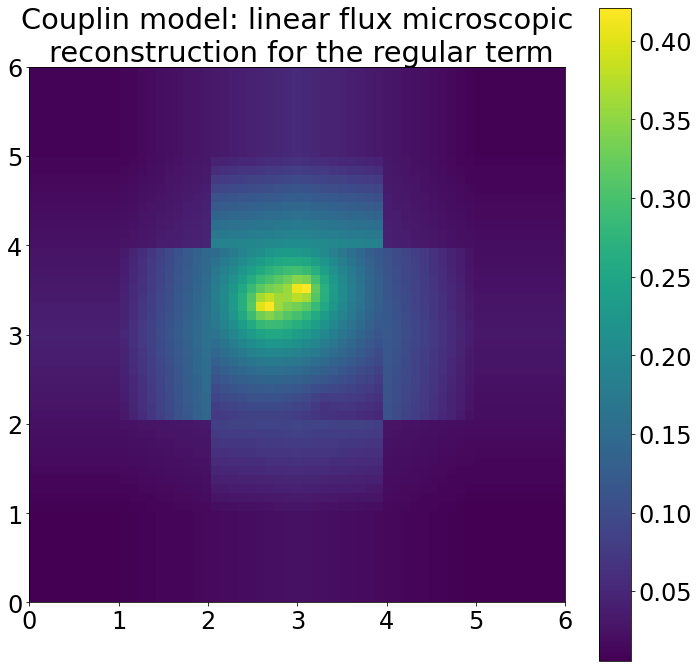

[ 0.45452895 -0.07212661  0.45433699]


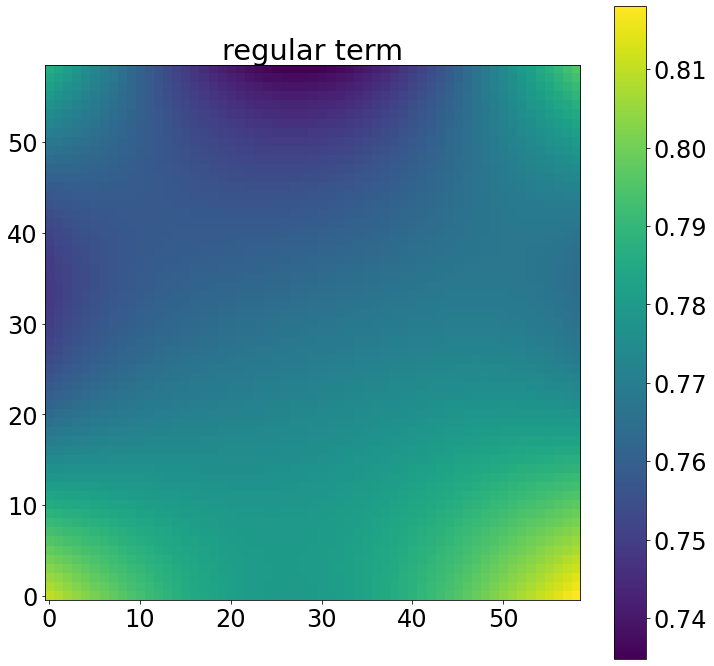

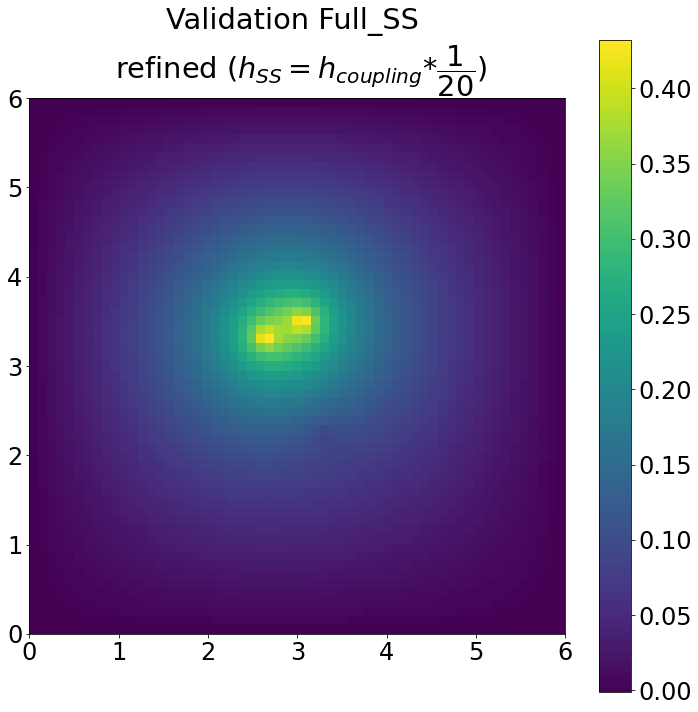

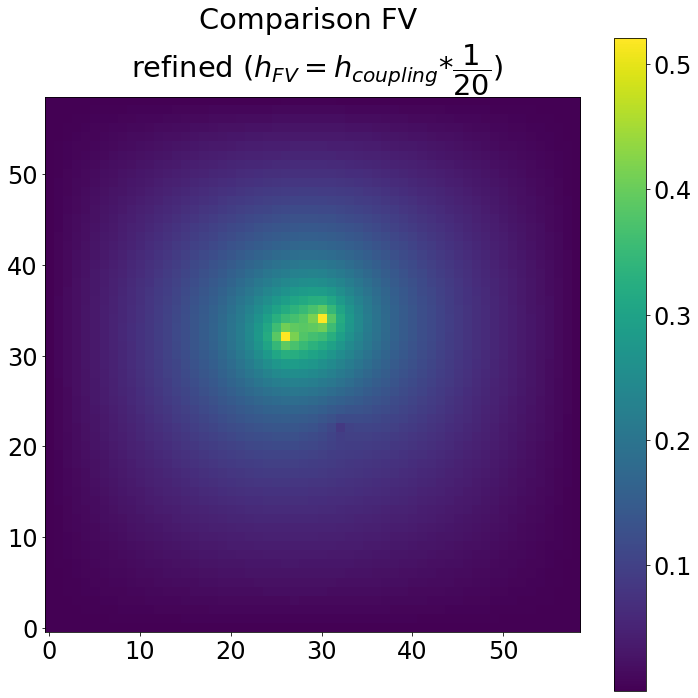

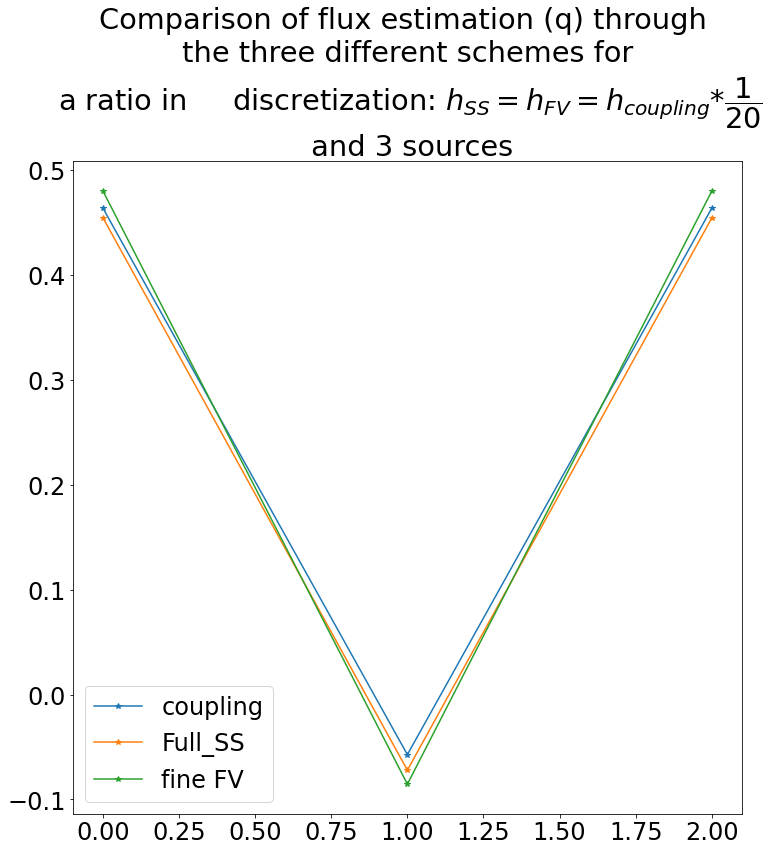

<Figure size 864x864 with 0 Axes>

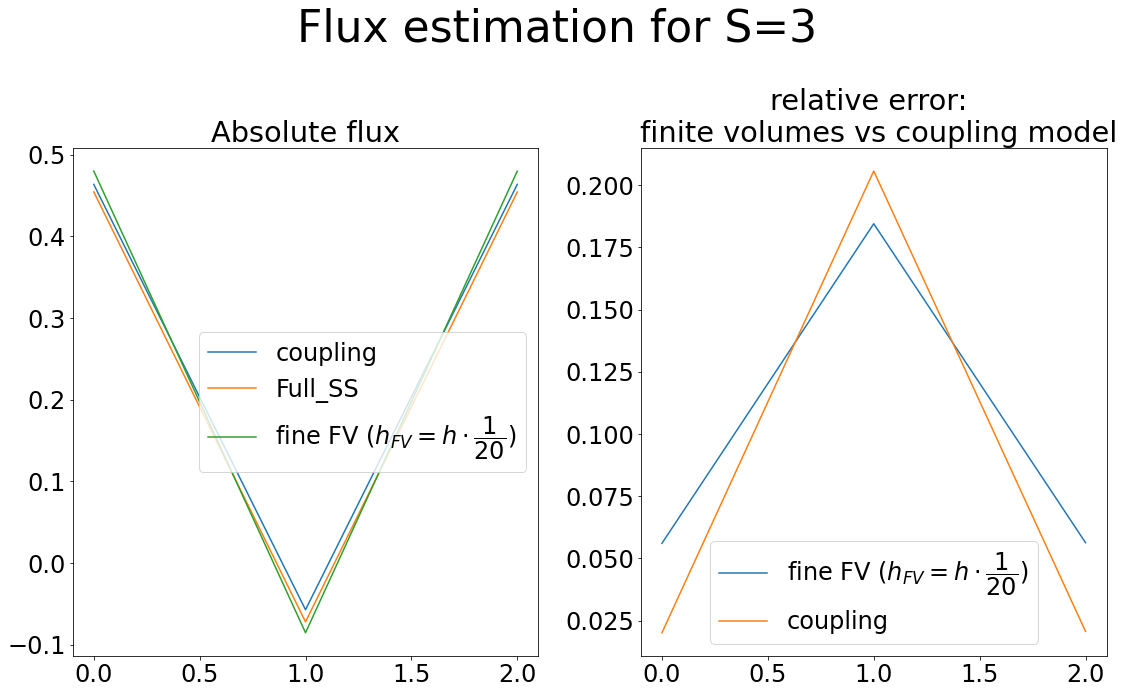

L^2 norm for the FV with 20 refinement= 0.038499376679728525
L^2 norm for the coupling with 1 refinement= 0.019802390297039885


In [341]:
execute_full_problem(2,20,3)

D=1, L=6, h_ss=2, ratio=40, #ofSources=30, Rv=0.01, K_eff=3183.098861837907


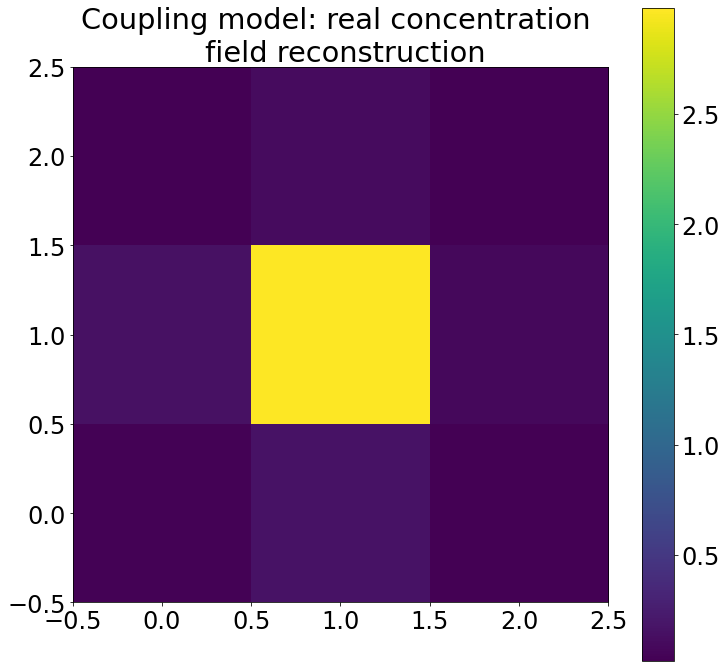

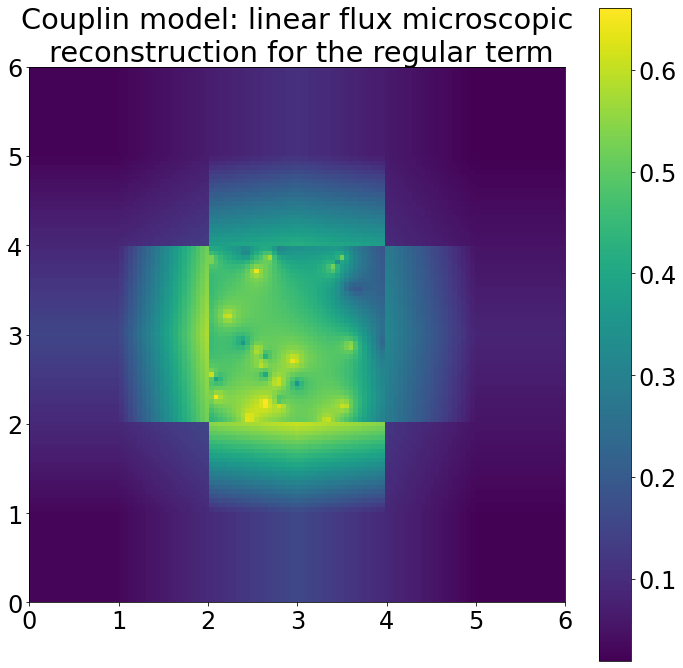

[ 0.39254339  0.4614757  -0.36452953  0.38133667  0.3428194   0.34893171
  0.30491837  0.31898774  0.33528189 -0.34802166  0.34509953  0.35886292
 -0.3826928  -0.40442838 -0.39543499 -0.19388886 -0.20860772  0.42271671
 -0.29998682  0.37274679  0.38638792  0.32510674  0.35872448 -0.35740742
 -0.29567823 -0.42772355  0.3307057   0.29461857 -0.21609107  0.3312896 ]


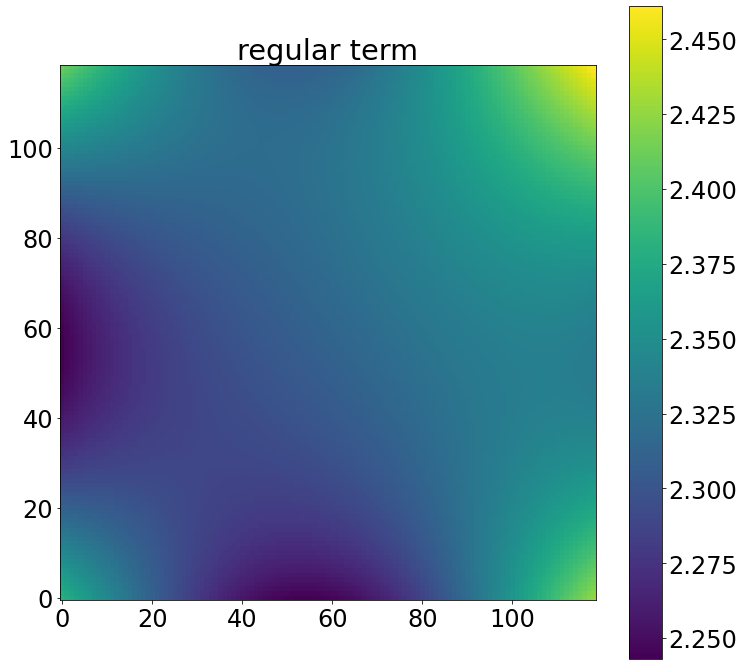

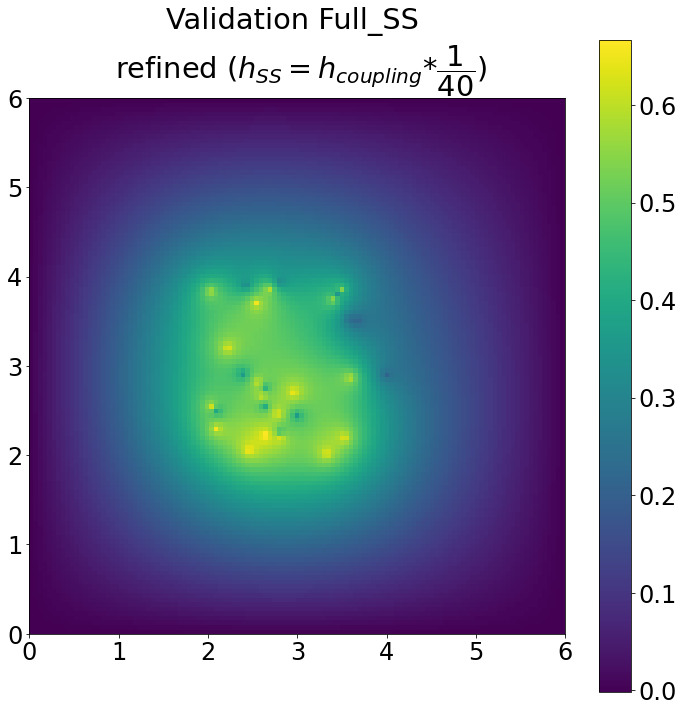

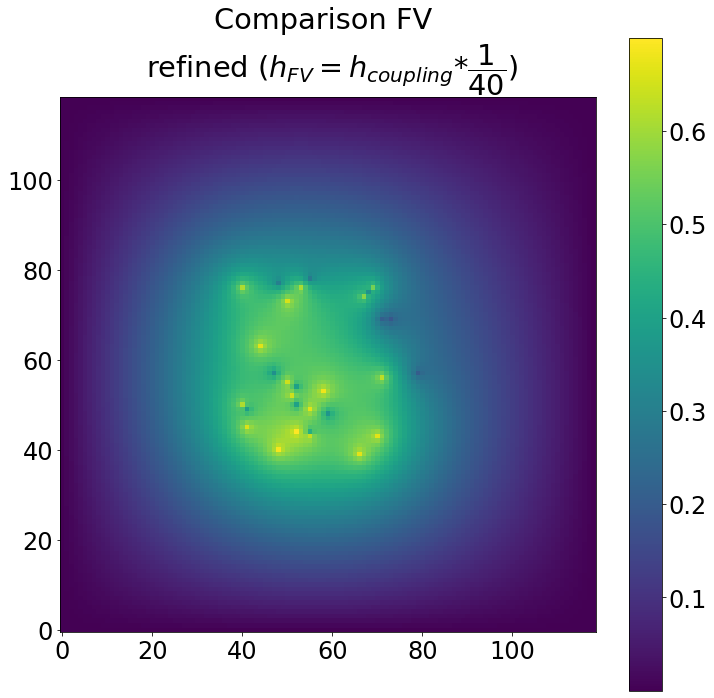

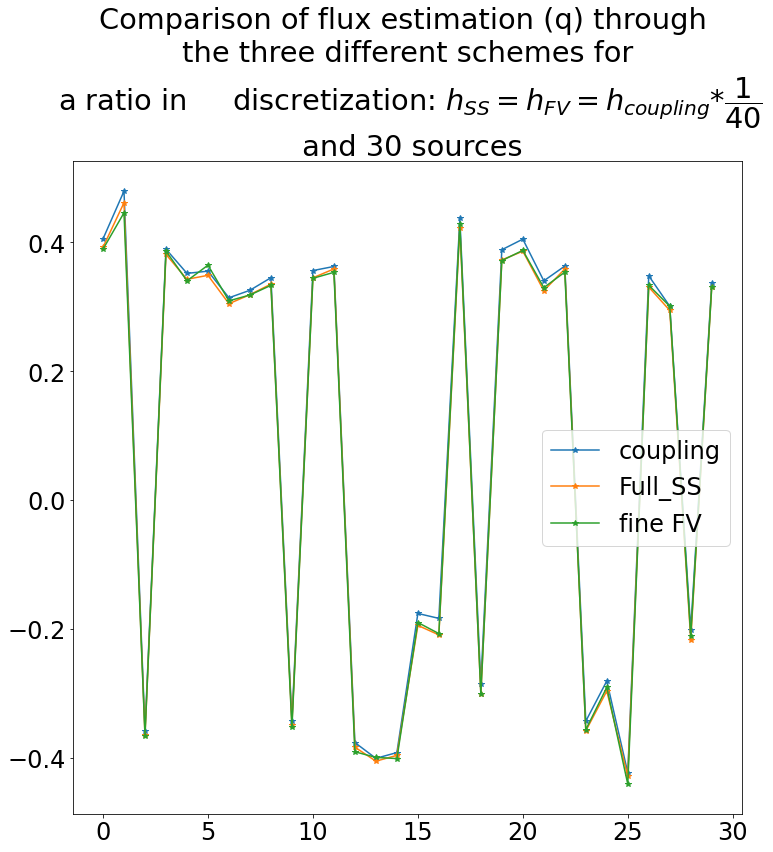

<Figure size 864x864 with 0 Axes>

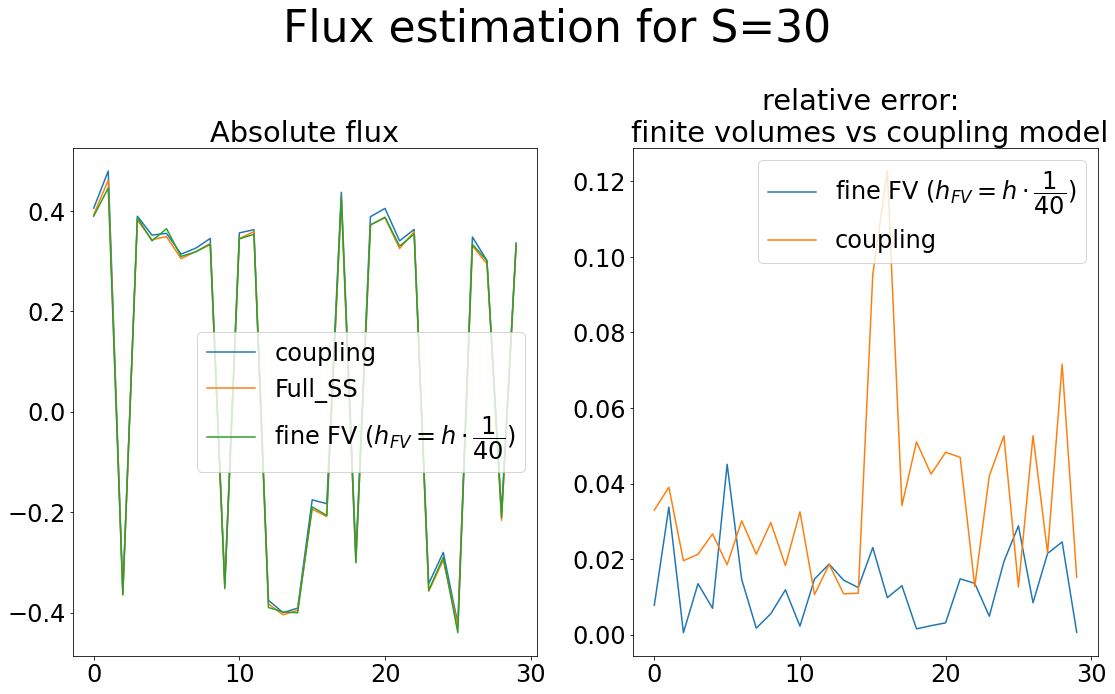

L^2 norm for the FV with 40 refinement= 0.03285142231016201
L^2 norm for the coupling with 1 refinement= 0.06808194719137495


In [342]:
execute_full_problem(2,40,30)